In [ ]:
import copy
import csv
import os
import warnings
from argparse import ArgumentParser
import numpy as np

import torch
from tqdm import tqdm
import yaml
from torch.utils import data
# 개별 json 라벨 파일을 이용해 학습 데이터 리스트 생성
import glob
import json
import os
from nets import ContextNn
from utils import util
import pandas as pd
from utils.dataset import Dataset
from torch.utils import data
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)
with open('utils/args.yaml', errors='ignore') as f:
    params = yaml.safe_load(f) 

In [ ]:
def crop_image_and_label(crop_h,crop_w,label,input_size):
    temp_labels = []
    for k in range(len(label)):
        x = label[k][2]
        y = label[k][1]
        w = label[k][4]
        h = label[k][3]
        if x >= crop_h and y >= crop_w and x <= crop_h + input_size and y <= crop_w + input_size:
            label[k][1] = (y+h/2 - crop_w)/ input_size
            label[k][2] = (x+w/2 - crop_h)/ input_size
            label[k][3] = (h) / input_size
            label[k][4] = (w) / input_size
            temp_labels.append(label[k])
    return temp_labels
    
def find_key_by_value(dictionary, target_value):
    """value로 key 찾기"""
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None 

input_size = 512
label_dir = '../../data/Brest_spatialTranscriptome/preprocessed_xenium/patch_train_data/**/annotation/'
label_files = sorted(glob.glob(f"{label_dir}/*.csv"))
image_filenames = []
tissue_image_filenames = []
labels = []
# 라벨이 존재하는 이미지
for label_file in label_files:
    data1 = pd.read_csv(label_file)

    img_path = label_file.replace('/annotation', '/image').replace('.csv', '.png')
    tissue_image_path=label_file.replace('/annotation', '/tissue_image').replace('.csv', '.png')
    if os.path.exists(img_path):
        image_filenames.append(img_path)
        tissue_image_filenames.append(tissue_image_path)
        arr = data1.to_numpy()
        arr=arr[:, [4, 1, 0 , 3, 2]]#class, y, x, h, w
        temp_labels=list(arr)
        labels.append(temp_labels)

images = []
tissue_image=[]
for i in tqdm(range(len(image_filenames))):
    image =cv2.imread(image_filenames[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
    tissue_img = cv2.imread(tissue_image_filenames[i])
    tissue_img = cv2.cvtColor(tissue_img, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
    tissue_image.append(tissue_img)
    images.append(image)


In [ ]:
def collate_fn1(batch):
    """Tissue context를 포함한 배치 collation"""
    samples, context_samples, cls, box, indices = zip(*batch)

    cls = torch.cat(cls, dim=0)
    box = torch.cat(box, dim=0)

    new_indices = list(indices)
    for i in range(len(indices)):
        new_indices[i] += i
    indices = torch.cat(new_indices, dim=0)

    targets = {'cls': cls,
                'box': box,
                'idx': indices}
    return torch.stack(samples, dim=0), torch.stack(context_samples, dim=0), targets

class custom_dataset(data.Dataset):
    def __init__(self, images, params, augment, labels, image_infos=None):
        self.params = params
        self.mosaic = augment
        self.augment = augment
        self.images = images[0]
        self.tissue_images = images[1]
        self.labels = labels
        self.scale_list = [256, 288, 320, 352, 384, 416, 448, 480, 512]
        self.current_scale = 512  # 배치 단위로 관리될 현재 스케일
        self.n = len(self.images)
        self.indices = list(range(self.n))
    
    def __len__(self):
        return len(self.indices)
    
    def set_scale(self, scale):
        """배치 단위로 스케일 설정"""
        self.current_scale = scale
    
    def random_multi_scale(self, image, label):
        # 현재 설정된 스케일 사용 (배치 내 모든 이미지가 동일한 크기)
        size = self.current_scale
        image = cv2.resize(image, (size, size))
        temp_labels = []
        for i in range(len(label)):
            x_center = label[i][1]
            y_center = label[i][2]
            w = label[i][3]
            h = label[i][4]
            temp_labels.append([label[i][0], y_center, x_center, h, w])
        return image, temp_labels
    
    def __getitem__(self, index):
        
        index = self.indices[index]
        image = self.images[index].copy()
        tissue_image = self.tissue_images[index].copy()
        label = self.labels[index]
        
        image,label=self.random_multi_scale(image,label)
        cls = []
        box = []
        for i in range(len(label)):
            cls.append(label[i][0])
            box.append(label[i][1:5])
        cls = np.array(cls)
        box = np.array(box)
        nl = len(box)
        
        if self.augment:
            # Flip up-down (메인 이미지와 tissue context 동시 적용)
            if random.random() < self.params['flip_ud']:
                image = np.flipud(image).copy()
                tissue_image = np.flipud(tissue_image).copy()
                if nl:
                    box[:, 1] = 1 - box[:, 1]
            
            # Flip left-right (메인 이미지와 tissue context 동시 적용)
            if random.random() < self.params['flip_lr']:
                image = np.fliplr(image).copy()
                tissue_image = np.fliplr(tissue_image).copy()
                if nl:
                    box[:, 0] = 1 - box[:, 0]

        # HWC -> CHW 변환
        image = image.transpose((2, 0, 1))
        tissue_image = tissue_image.transpose((2, 0, 1))
        
        return (torch.from_numpy(image), 
                torch.from_numpy(tissue_image),  # tissue context 추가
                torch.from_numpy(cls), 
                torch.from_numpy(box), 
                torch.zeros(nl))
    

split=[0.9, 0.1]
patch_train, patch_test, tissue_train, tissue_test, label_train, label_test = train_test_split(
    images, tissue_image, labels, 
    test_size=0.15,
    random_state=242,
    shuffle=True
)

# Dataset 생성
train_dataset = custom_dataset((patch_train, tissue_train), params, augment=True, labels=label_train)
val_dataset = custom_dataset((patch_test, tissue_test), params, augment=False, labels=label_test)

In [ ]:
def visualize_sample_with_overlay(dataset, index=0):
    """
    데이터셋의 특정 샘플에 대해 바운딩 박스를 오버레이한 이미지를 시각화합니다.
    메인 이미지와 tissue context 이미지를 함께 표시합니다.
    
    Args:
        dataset: 커스텀 데이터셋
        index: 시각화할 샘플의 인덱스
    """
    # 샘플 가져오기 (tissue context 포함)
    image_tensor, tissue_tensor, cls_tensor, box_tensor, _ = dataset[index]
    
    # 텐서를 numpy 배열로 변환
    # 이미지: (C, H, W) -> (H, W, C)
    image = image_tensor.numpy().transpose(1, 2, 0)
    tissue_image = tissue_tensor.numpy().transpose(1, 2, 0)
    cls = cls_tensor.numpy()
    boxes = box_tensor.numpy()

    # 이미지 크기
    height, width = image.shape[:2]
    
    # 클래스 이름 및 색상 설정
    class_names = {
    0: "Tumor epithelial",
    1: "Non-tumor epithelial",
    2: "Basal/Myoepithelial",
    3: "Smooth muscle",
    4: "Fibroblast",
    5: "Endothelial",
    6: "T cell",
    7: "B cell",
    8: "Plasma cell",
    9: "Myeloid",
    10: "Adipocyte",
    11: "Other/Unknown"}
    colors = ["#FF0000","#FFB6C1","#FFA500",
    "#8B4513",
    "#00FF00",
    "#0000FF",
    "#FFFF00",
    "#FF00FF",
    "#9400D3",
    "#00FFFF",
    "#FFC0CB",
    "#808080"]
    # 시각화: 메인 이미지와 tissue context를 나란히 표시
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # 메인 이미지
    axes[0].imshow(image.astype(np.uint8))
    for i in range(len(boxes)):
        center_x, center_y, box_width, box_height = boxes[i]
        center_x_pixel = center_x * width
        center_y_pixel = center_y * height
        box_w_pixel = box_width * width
        box_h_pixel = box_height * height
        
        # 좌상단 좌표 계산 (중심점 -> 좌상단)
        x1 = center_x_pixel - box_w_pixel / 2
        y1 = center_y_pixel - box_h_pixel / 2
        
        class_id = int(cls[i])
        color = colors[class_id] if class_id < len(colors) else 'green'
        
        # Bounding box 그리기
        rect = patches.Rectangle((x1, y1), box_w_pixel, box_h_pixel, 
                                 linewidth=2, edgecolor=color, facecolor='none')
        axes[0].add_patch(rect)
    
    axes[0].set_title(f'Main Image - Sample {index}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Tissue Context 이미지
    axes[1].imshow(tissue_image.astype(np.uint8))
    axes[1].set_title(f'Tissue Context - Sample {index}', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    fig.suptitle(f'Dataset Sample {index}\nTotal Objects: {len(boxes)} | '
                f'Class Distribution: {[f"{i}:{sum(cls==i)}" for i in range(12)]}',
                fontsize=14, fontweight='bold')
    
    # 범례 추가
    legend_elements = [
        patches.Patch(color='#FF0000', label='0:Tumor epi'),
        patches.Patch(color='#FFB6C1', label='1:Non-tumor epi'),
        patches.Patch(color='#FFA500', label='2:Basal/Myo'),
        patches.Patch(color='#8B4513', label='3:Smooth muscle'),
        patches.Patch(color='#00FF00', label='4:Fibroblast'),
        patches.Patch(color='#0000FF', label='5:Endothelial'),
        patches.Patch(color='#FFFF00', label='6:T cell'),
        patches.Patch(color='#FF00FF', label='7:B cell'),
        patches.Patch(color='#9400D3', label='8:Plasma cell'),
        patches.Patch(color='#00FFFF', label='9:Myeloid'),
        patches.Patch(color='#FFC0CB', label='10:Adipocyte'),
        patches.Patch(color='#808080', label='11:Other'),
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=6, 
               bbox_to_anchor=(0.5, -0.05), fontsize=9)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)
    plt.show()
    
    # 상세 정보 출력
    print(f"📊 Sample {index} 상세 정보:")
    print(f"  메인 이미지 크기: {width} x {height}")
    print(f"  Tissue context 크기: {tissue_image.shape[1]} x {tissue_image.shape[0]}")
    print(f"  총 객체 수: {len(boxes)}")
    print(f"  클래스별 분포:")
    for class_id in range(12):
        count = sum(cls == class_id)
        if count > 0:
            print(f"    Class {class_id}: {count}개")
    
    print("\n🔍 처음 5개 객체 정보:")
    for i in range(min(5, len(boxes))):
        center_x, center_y, box_w, box_h = boxes[i]
        class_id = int(cls[i])
        class_name = class_names.get(class_id, f'Class {class_id}')
        print(f"  객체 {i+1}: {class_name} | 중심점: ({center_x:.3f}, {center_y:.3f}) | 크기: {box_w:.3f} x {box_h:.3f}")

# train_dataset 시각화 실행
print("🖼️ Train Dataset 샘플 시각화 (메인 이미지 + Tissue Context)")
print("=" * 70)
visualize_sample_with_overlay(train_dataset, index=200)

In [ ]:


# 모델 및 파라미터 준비 (Tissue context 활성화)
model = ContextNn.yolo_v11_m(len(params['names']), use_context=True, context_backbone='efficientnet_b1').to(device)
optimizer = torch.optim.AdamW(util.set_params(model, params['weight_decay']),
                             lr=2e-4, 
                             betas=(0.9, 0.999),
                             weight_decay=params['weight_decay'])
criterion = util.ComputeLoss(model, params)

# 데이터셋 및 데이터로드 (안전한 함수 사용)
batch_size = 32
# 안전하게 데이터로더 생성하는 함수
def create_safe_loader(dataset, batch_size, is_train=True):
    """
    배치 크기에 맞게 데이터셋을 조정하여 안전하게 데이터로더를 생성하는 함수
    """
    dataset_size = len(dataset)
    
    # 배치 크기가 데이터셋 크기보다 큰 경우 배치 크기 조정
    if dataset_size < batch_size:
        print(f"경고: 데이터셋 크기({dataset_size})가 배치 크기({batch_size})보다 작습니다. 배치 크기를 {dataset_size}로 조정합니다.")
        actual_batch_size = max(1, dataset_size)
    else:
        actual_batch_size = batch_size
    
    # 데이터셋이 배치 크기로 나누어 떨어지는지 확인
    if dataset_size % actual_batch_size != 0:
        print(f"참고: 데이터셋 크기({dataset_size})가 배치 크기({actual_batch_size})로 나누어 떨어지지 않습니다.")
        print(f"마지막 배치는 {dataset_size % actual_batch_size}개의 샘플을 포함합니다.")
    
    # 데이터로더 생성
    loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=actual_batch_size, 
        shuffle=is_train,
        num_workers=4,
        collate_fn=collate_fn1,
        drop_last=(not is_train)  # 훈련 시에는 마지막 배치 유지, 검증 시에는 마지막 배치 제외
    )
    
    return loader, actual_batch_size
# 안전하게 데이터로더 생성
loader, train_batch_size = create_safe_loader(train_dataset, batch_size, is_train=True)
val_loader, val_batch_size = create_safe_loader(val_dataset, batch_size, is_train=False)

print(f"최종 훈련 배치 크기: {train_batch_size}")
print(f"최종 검증 배치 크기: {val_batch_size}")




Epoch 223/10000 Results:
  Train Loss - Box: 0.6920, Cls: 0.6360, DFL: 0.5328, Total: 1.8608
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6941 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3179
  Macro Recall: 0.2176
  Macro F1-score: 0.2534 ⭐
  Overall Recall: 0.5024


Epoch 224/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 224/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 224/10000 Results:
  Train Loss - Box: 0.6915, Cls: 0.6351, DFL: 0.5328, Total: 1.8594
🎯 Point-Label Metrics:
  Detection Recall: 0.7251 (GT 중 찾은 비율)
  Classification Accuracy: 0.6959 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3162
  Macro Recall: 0.2207
  Macro F1-score: 0.2557 ⭐
  Overall Recall: 0.5046


Epoch 225/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 225/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 225/10000 Results:
  Train Loss - Box: 0.6889, Cls: 0.6320, DFL: 0.5326, Total: 1.8535
🎯 Point-Label Metrics:
  Detection Recall: 0.7239 (GT 중 찾은 비율)
  Classification Accuracy: 0.6941 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3081
  Macro Recall: 0.2156
  Macro F1-score: 0.2497 ⭐
  Overall Recall: 0.5024


Epoch 226/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 226/10000 Results:
  Train Loss - Box: 0.6912, Cls: 0.6349, DFL: 0.5327, Total: 1.8589
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3053
  Macro Recall: 0.2200
  Macro F1-score: 0.2522 ⭐
  Overall Recall: 0.5015


Epoch 227/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 227/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 227/10000 Results:
  Train Loss - Box: 0.6906, Cls: 0.6347, DFL: 0.5328, Total: 1.8581
🎯 Point-Label Metrics:
  Detection Recall: 0.7248 (GT 중 찾은 비율)
  Classification Accuracy: 0.6964 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3122
  Macro Recall: 0.2166
  Macro F1-score: 0.2510 ⭐
  Overall Recall: 0.5047


Epoch 228/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 228/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 228/10000 Results:
  Train Loss - Box: 0.6895, Cls: 0.6334, DFL: 0.5326, Total: 1.8555
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6959 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3120
  Macro Recall: 0.2225
  Macro F1-score: 0.2570 ⭐
  Overall Recall: 0.5039


Epoch 229/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 229/10000 Results:
  Train Loss - Box: 0.6899, Cls: 0.6340, DFL: 0.5327, Total: 1.8566
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3091
  Macro Recall: 0.2140
  Macro F1-score: 0.2489 ⭐
  Overall Recall: 0.5029


Epoch 230/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.636 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 230/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.636 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 230/10000 Results:
  Train Loss - Box: 0.6912, Cls: 0.6359, DFL: 0.5328, Total: 1.8599
🎯 Point-Label Metrics:
  Detection Recall: 0.7252 (GT 중 찾은 비율)
  Classification Accuracy: 0.6969 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3128
  Macro Recall: 0.2234
  Macro F1-score: 0.2573 ⭐
  Overall Recall: 0.5053

📊 Epoch 230 - 검증 샘플 1/1:

📊 Epoch 230 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_230.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_230.png


Epoch 231/10000 | Memory: 33.16G | Box: 0.692 | Cls: 0.636 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 231/10000 | Memory: 33.16G | Box: 0.692 | Cls: 0.636 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 231/10000 Results:
  Train Loss - Box: 0.6916, Cls: 0.6358, DFL: 0.5328, Total: 1.8602
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6928 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3138
  Macro Recall: 0.2208
  Macro F1-score: 0.2556 ⭐
  Overall Recall: 0.5023


Epoch 232/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 232/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 232/10000 Results:
  Train Loss - Box: 0.6908, Cls: 0.6346, DFL: 0.5328, Total: 1.8582
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6942 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3134
  Macro Recall: 0.2243
  Macro F1-score: 0.2578 ⭐
  Overall Recall: 0.5033


Epoch 233/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 233/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 233/10000 Results:
  Train Loss - Box: 0.6913, Cls: 0.6349, DFL: 0.5328, Total: 1.8590
🎯 Point-Label Metrics:
  Detection Recall: 0.7266 (GT 중 찾은 비율)
  Classification Accuracy: 0.6955 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3108
  Macro Recall: 0.2167
  Macro F1-score: 0.2511 ⭐
  Overall Recall: 0.5054


Epoch 234/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 234/10000 Results:
  Train Loss - Box: 0.6901, Cls: 0.6344, DFL: 0.5327, Total: 1.8571
🎯 Point-Label Metrics:
  Detection Recall: 0.7231 (GT 중 찾은 비율)
  Classification Accuracy: 0.6926 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3143
  Macro Recall: 0.2191
  Macro F1-score: 0.2537 ⭐
  Overall Recall: 0.5008


Epoch 235/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 235/10000 Results:
  Train Loss - Box: 0.6911, Cls: 0.6353, DFL: 0.5328, Total: 1.8592
🎯 Point-Label Metrics:
  Detection Recall: 0.7244 (GT 중 찾은 비율)
  Classification Accuracy: 0.6949 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3122
  Macro Recall: 0.2243
  Macro F1-score: 0.2584 ⭐
  Overall Recall: 0.5034


Epoch 236/10000 | Memory: 33.16G | Box: 0.692 | Cls: 0.636 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 236/10000 | Memory: 33.16G | Box: 0.692 | Cls: 0.636 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 236/10000 Results:
  Train Loss - Box: 0.6918, Cls: 0.6362, DFL: 0.5328, Total: 1.8608
🎯 Point-Label Metrics:
  Detection Recall: 0.7217 (GT 중 찾은 비율)
  Classification Accuracy: 0.6894 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3090
  Macro Recall: 0.2209
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.4976


Epoch 237/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 237/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 237/10000 Results:
  Train Loss - Box: 0.6899, Cls: 0.6340, DFL: 0.5327, Total: 1.8565
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6908 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3077
  Macro Recall: 0.2231
  Macro F1-score: 0.2563 ⭐
  Overall Recall: 0.5001


Epoch 238/10000 | Memory: 33.16G | Box: 0.692 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 238/10000 | Memory: 33.16G | Box: 0.692 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 238/10000 Results:
  Train Loss - Box: 0.6915, Cls: 0.6353, DFL: 0.5328, Total: 1.8596
🎯 Point-Label Metrics:
  Detection Recall: 0.7251 (GT 중 찾은 비율)
  Classification Accuracy: 0.6956 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3141
  Macro Recall: 0.2184
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5044


Epoch 239/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 239/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 239/10000 Results:
  Train Loss - Box: 0.6906, Cls: 0.6342, DFL: 0.5327, Total: 1.8575
🎯 Point-Label Metrics:
  Detection Recall: 0.7251 (GT 중 찾은 비율)
  Classification Accuracy: 0.6951 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3089
  Macro Recall: 0.2189
  Macro F1-score: 0.2527 ⭐
  Overall Recall: 0.5040


Epoch 240/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 240/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 240/10000 Results:
  Train Loss - Box: 0.6913, Cls: 0.6349, DFL: 0.5328, Total: 1.8590
🎯 Point-Label Metrics:
  Detection Recall: 0.7225 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3070
  Macro Recall: 0.2253
  Macro F1-score: 0.2568 ⭐
  Overall Recall: 0.5005

📊 Epoch 240 - 검증 샘플 1/1:

📊 Epoch 240 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_240.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_240.png


Epoch 241/10000 | Memory: 33.16G | Box: 0.692 | Cls: 0.636 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 241/10000 Results:
  Train Loss - Box: 0.6919, Cls: 0.6361, DFL: 0.5328, Total: 1.8607
🎯 Point-Label Metrics:
  Detection Recall: 0.7221 (GT 중 찾은 비율)
  Classification Accuracy: 0.6937 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3144
  Macro Recall: 0.2235
  Macro F1-score: 0.2575 ⭐
  Overall Recall: 0.5010


Epoch 242/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 242/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 242/10000 Results:
  Train Loss - Box: 0.6911, Cls: 0.6353, DFL: 0.5328, Total: 1.8592
🎯 Point-Label Metrics:
  Detection Recall: 0.7263 (GT 중 찾은 비율)
  Classification Accuracy: 0.6969 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3170
  Macro Recall: 0.2188
  Macro F1-score: 0.2543 ⭐
  Overall Recall: 0.5062


Epoch 243/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 243/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 243/10000 Results:
  Train Loss - Box: 0.6896, Cls: 0.6335, DFL: 0.5327, Total: 1.8558
🎯 Point-Label Metrics:
  Detection Recall: 0.7236 (GT 중 찾은 비율)
  Classification Accuracy: 0.6954 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3137
  Macro Recall: 0.2077
  Macro F1-score: 0.2445 ⭐
  Overall Recall: 0.5031


Epoch 244/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 244/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 244/10000 Results:
  Train Loss - Box: 0.6892, Cls: 0.6330, DFL: 0.5326, Total: 1.8549
🎯 Point-Label Metrics:
  Detection Recall: 0.7239 (GT 중 찾은 비율)
  Classification Accuracy: 0.6964 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3140
  Macro Recall: 0.2174
  Macro F1-score: 0.2531 ⭐
  Overall Recall: 0.5041


Epoch 245/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 245/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 245/10000 Results:
  Train Loss - Box: 0.6889, Cls: 0.6323, DFL: 0.5326, Total: 1.8538
🎯 Point-Label Metrics:
  Detection Recall: 0.7234 (GT 중 찾은 비율)
  Classification Accuracy: 0.6936 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3100
  Macro Recall: 0.2234
  Macro F1-score: 0.2565 ⭐
  Overall Recall: 0.5018


Epoch 246/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 246/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 246/10000 Results:
  Train Loss - Box: 0.6910, Cls: 0.6350, DFL: 0.5327, Total: 1.8588
🎯 Point-Label Metrics:
  Detection Recall: 0.7225 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3119
  Macro Recall: 0.2241
  Macro F1-score: 0.2578 ⭐
  Overall Recall: 0.5008


Epoch 247/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 247/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 247/10000 Results:
  Train Loss - Box: 0.6901, Cls: 0.6341, DFL: 0.5327, Total: 1.8568
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6917 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3125
  Macro Recall: 0.2222
  Macro F1-score: 0.2563 ⭐
  Overall Recall: 0.5014


Epoch 248/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 248/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 248/10000 Results:
  Train Loss - Box: 0.6904, Cls: 0.6345, DFL: 0.5327, Total: 1.8576
🎯 Point-Label Metrics:
  Detection Recall: 0.7237 (GT 중 찾은 비율)
  Classification Accuracy: 0.6955 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3158
  Macro Recall: 0.2210
  Macro F1-score: 0.2562 ⭐
  Overall Recall: 0.5034


Epoch 249/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 249/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 249/10000 Results:
  Train Loss - Box: 0.6889, Cls: 0.6322, DFL: 0.5326, Total: 1.8537
🎯 Point-Label Metrics:
  Detection Recall: 0.7230 (GT 중 찾은 비율)
  Classification Accuracy: 0.6925 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3158
  Macro Recall: 0.2204
  Macro F1-score: 0.2554 ⭐
  Overall Recall: 0.5006


Epoch 250/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 250/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 250/10000 Results:
  Train Loss - Box: 0.6902, Cls: 0.6342, DFL: 0.5327, Total: 1.8571
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6966 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3180
  Macro Recall: 0.2198
  Macro F1-score: 0.2558 ⭐
  Overall Recall: 0.5042

📊 Epoch 250 - 검증 샘플 1/1:

📊 Epoch 250 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_250.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_250.png


Epoch 251/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 251/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 251/10000 Results:
  Train Loss - Box: 0.6898, Cls: 0.6333, DFL: 0.5327, Total: 1.8558
🎯 Point-Label Metrics:
  Detection Recall: 0.7252 (GT 중 찾은 비율)
  Classification Accuracy: 0.6945 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3117
  Macro Recall: 0.2227
  Macro F1-score: 0.2566 ⭐
  Overall Recall: 0.5037


Epoch 252/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.62it/s]
Epoch 252/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.62it/s]



Epoch 252/10000 Results:
  Train Loss - Box: 0.6911, Cls: 0.6345, DFL: 0.5327, Total: 1.8583
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3121
  Macro Recall: 0.2230
  Macro F1-score: 0.2570 ⭐
  Overall Recall: 0.5019


Epoch 253/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 253/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 253/10000 Results:
  Train Loss - Box: 0.6897, Cls: 0.6331, DFL: 0.5326, Total: 1.8554
🎯 Point-Label Metrics:
  Detection Recall: 0.7237 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3150
  Macro Recall: 0.2213
  Macro F1-score: 0.2563 ⭐
  Overall Recall: 0.5013


Epoch 254/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 254/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 254/10000 Results:
  Train Loss - Box: 0.6890, Cls: 0.6328, DFL: 0.5326, Total: 1.8544
🎯 Point-Label Metrics:
  Detection Recall: 0.7265 (GT 중 찾은 비율)
  Classification Accuracy: 0.6942 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3158
  Macro Recall: 0.2228
  Macro F1-score: 0.2581 ⭐
  Overall Recall: 0.5044


Epoch 255/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 255/10000 | Memory: 33.16G | Box: 0.691 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 255/10000 Results:
  Train Loss - Box: 0.6907, Cls: 0.6343, DFL: 0.5327, Total: 1.8576
🎯 Point-Label Metrics:
  Detection Recall: 0.7226 (GT 중 찾은 비율)
  Classification Accuracy: 0.6928 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3104
  Macro Recall: 0.2204
  Macro F1-score: 0.2545 ⭐
  Overall Recall: 0.5006


Epoch 256/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 256/10000 Results:
  Train Loss - Box: 0.6890, Cls: 0.6322, DFL: 0.5326, Total: 1.8539
🎯 Point-Label Metrics:
  Detection Recall: 0.7228 (GT 중 찾은 비율)
  Classification Accuracy: 0.6963 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3143
  Macro Recall: 0.2246
  Macro F1-score: 0.2578 ⭐
  Overall Recall: 0.5033


Epoch 257/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 257/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 257/10000 Results:
  Train Loss - Box: 0.6879, Cls: 0.6309, DFL: 0.5326, Total: 1.8514
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3126
  Macro Recall: 0.2212
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5027


Epoch 258/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 258/10000 Results:
  Train Loss - Box: 0.6882, Cls: 0.6313, DFL: 0.5326, Total: 1.8522
🎯 Point-Label Metrics:
  Detection Recall: 0.7279 (GT 중 찾은 비율)
  Classification Accuracy: 0.6921 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3157
  Macro Recall: 0.2183
  Macro F1-score: 0.2531 ⭐
  Overall Recall: 0.5037


Epoch 259/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:32<00:00,  4.61it/s]
Epoch 259/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:32<00:00,  4.61it/s]



Epoch 259/10000 Results:
  Train Loss - Box: 0.6879, Cls: 0.6309, DFL: 0.5325, Total: 1.8513
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6954 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3113
  Macro Recall: 0.2198
  Macro F1-score: 0.2533 ⭐
  Overall Recall: 0.5039


Epoch 260/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 260/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 260/10000 Results:
  Train Loss - Box: 0.6884, Cls: 0.6319, DFL: 0.5326, Total: 1.8529
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6920 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3087
  Macro Recall: 0.2201
  Macro F1-score: 0.2538 ⭐
  Overall Recall: 0.5002

📊 Epoch 260 - 검증 샘플 1/1:

📊 Epoch 260 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_260.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_260.png


Epoch 261/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.62it/s]
Epoch 261/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.62it/s]



Epoch 261/10000 Results:
  Train Loss - Box: 0.6890, Cls: 0.6325, DFL: 0.5326, Total: 1.8541
🎯 Point-Label Metrics:
  Detection Recall: 0.7236 (GT 중 찾은 비율)
  Classification Accuracy: 0.6970 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3155
  Macro Recall: 0.2192
  Macro F1-score: 0.2543 ⭐
  Overall Recall: 0.5043


Epoch 262/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 262/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 262/10000 Results:
  Train Loss - Box: 0.6896, Cls: 0.6331, DFL: 0.5326, Total: 1.8554
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6954 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3167
  Macro Recall: 0.2231
  Macro F1-score: 0.2581 ⭐
  Overall Recall: 0.5031


Epoch 263/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 263/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 263/10000 Results:
  Train Loss - Box: 0.6877, Cls: 0.6305, DFL: 0.5325, Total: 1.8508
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6922 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3101
  Macro Recall: 0.2220
  Macro F1-score: 0.2552 ⭐
  Overall Recall: 0.5016


Epoch 264/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 264/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 264/10000 Results:
  Train Loss - Box: 0.6871, Cls: 0.6304, DFL: 0.5324, Total: 1.8499
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6932 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3104
  Macro Recall: 0.2207
  Macro F1-score: 0.2544 ⭐
  Overall Recall: 0.5017


Epoch 265/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 265/10000 Results:
  Train Loss - Box: 0.6890, Cls: 0.6323, DFL: 0.5326, Total: 1.8538
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6944 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3104
  Macro Recall: 0.2179
  Macro F1-score: 0.2517 ⭐
  Overall Recall: 0.5031


Epoch 266/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 266/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 266/10000 Results:
  Train Loss - Box: 0.6903, Cls: 0.6340, DFL: 0.5327, Total: 1.8570
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6963 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3145
  Macro Recall: 0.2187
  Macro F1-score: 0.2543 ⭐
  Overall Recall: 0.5042


Epoch 267/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 267/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 267/10000 Results:
  Train Loss - Box: 0.6887, Cls: 0.6326, DFL: 0.5326, Total: 1.8538
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6964 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3157
  Macro Recall: 0.2249
  Macro F1-score: 0.2595 ⭐
  Overall Recall: 0.5044


Epoch 268/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 268/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.635 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 268/10000 Results:
  Train Loss - Box: 0.6904, Cls: 0.6351, DFL: 0.5327, Total: 1.8582
🎯 Point-Label Metrics:
  Detection Recall: 0.7257 (GT 중 찾은 비율)
  Classification Accuracy: 0.6961 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3129
  Macro Recall: 0.2154
  Macro F1-score: 0.2504 ⭐
  Overall Recall: 0.5051


Epoch 269/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 269/10000 Results:
  Train Loss - Box: 0.6899, Cls: 0.6331, DFL: 0.5326, Total: 1.8556
🎯 Point-Label Metrics:
  Detection Recall: 0.7231 (GT 중 찾은 비율)
  Classification Accuracy: 0.6929 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3160
  Macro Recall: 0.2217
  Macro F1-score: 0.2564 ⭐
  Overall Recall: 0.5011


Epoch 270/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 270/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 270/10000 Results:
  Train Loss - Box: 0.6892, Cls: 0.6328, DFL: 0.5326, Total: 1.8547
🎯 Point-Label Metrics:
  Detection Recall: 0.7236 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3125
  Macro Recall: 0.2184
  Macro F1-score: 0.2533 ⭐
  Overall Recall: 0.5021

📊 Epoch 270 - 검증 샘플 1/1:

📊 Epoch 270 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_270.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_270.png


Epoch 271/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:32<00:00,  4.62it/s]
Epoch 271/10000 | Memory: 33.16G | Box: 0.690 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:32<00:00,  4.62it/s]



Epoch 271/10000 Results:
  Train Loss - Box: 0.6902, Cls: 0.6343, DFL: 0.5327, Total: 1.8572
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3069
  Macro Recall: 0.2240
  Macro F1-score: 0.2564 ⭐
  Overall Recall: 0.5014


Epoch 272/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 272/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 272/10000 Results:
  Train Loss - Box: 0.6878, Cls: 0.6314, DFL: 0.5326, Total: 1.8517
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3114
  Macro Recall: 0.2209
  Macro F1-score: 0.2552 ⭐
  Overall Recall: 0.5022


Epoch 273/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 273/10000 Results:
  Train Loss - Box: 0.6890, Cls: 0.6331, DFL: 0.5326, Total: 1.8547
🎯 Point-Label Metrics:
  Detection Recall: 0.7256 (GT 중 찾은 비율)
  Classification Accuracy: 0.6952 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3165
  Macro Recall: 0.2163
  Macro F1-score: 0.2523 ⭐
  Overall Recall: 0.5044


Epoch 274/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 274/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 274/10000 Results:
  Train Loss - Box: 0.6881, Cls: 0.6317, DFL: 0.5325, Total: 1.8523
🎯 Point-Label Metrics:
  Detection Recall: 0.7261 (GT 중 찾은 비율)
  Classification Accuracy: 0.6909 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3108
  Macro Recall: 0.2161
  Macro F1-score: 0.2510 ⭐
  Overall Recall: 0.5017


Epoch 275/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 275/10000 Results:
  Train Loss - Box: 0.6894, Cls: 0.6328, DFL: 0.5326, Total: 1.8548
🎯 Point-Label Metrics:
  Detection Recall: 0.7231 (GT 중 찾은 비율)
  Classification Accuracy: 0.6918 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3138
  Macro Recall: 0.2186
  Macro F1-score: 0.2540 ⭐
  Overall Recall: 0.5002


Epoch 276/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 276/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.634 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 276/10000 Results:
  Train Loss - Box: 0.6893, Cls: 0.6336, DFL: 0.5326, Total: 1.8555
🎯 Point-Label Metrics:
  Detection Recall: 0.7244 (GT 중 찾은 비율)
  Classification Accuracy: 0.6925 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3126
  Macro Recall: 0.2189
  Macro F1-score: 0.2537 ⭐
  Overall Recall: 0.5016


Epoch 277/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]




Epoch 277/10000 Results:
  Train Loss - Box: 0.6893, Cls: 0.6328, DFL: 0.5326, Total: 1.8547
🎯 Point-Label Metrics:
  Detection Recall: 0.7255 (GT 중 찾은 비율)
  Classification Accuracy: 0.6970 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3137
  Macro Recall: 0.2189
  Macro F1-score: 0.2536 ⭐
  Overall Recall: 0.5056


Epoch 278/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:32<00:00,  4.62it/s]
Epoch 278/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:32<00:00,  4.62it/s]



Epoch 278/10000 Results:
  Train Loss - Box: 0.6883, Cls: 0.6323, DFL: 0.5326, Total: 1.8531
🎯 Point-Label Metrics:
  Detection Recall: 0.7248 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3155
  Macro Recall: 0.2238
  Macro F1-score: 0.2584 ⭐
  Overall Recall: 0.5021


Epoch 279/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 279/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 279/10000 Results:
  Train Loss - Box: 0.6881, Cls: 0.6319, DFL: 0.5325, Total: 1.8525
🎯 Point-Label Metrics:
  Detection Recall: 0.7244 (GT 중 찾은 비율)
  Classification Accuracy: 0.6961 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3115
  Macro Recall: 0.2237
  Macro F1-score: 0.2566 ⭐
  Overall Recall: 0.5042


Epoch 280/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 280/10000 Results:
  Train Loss - Box: 0.6870, Cls: 0.6301, DFL: 0.5325, Total: 1.8496
🎯 Point-Label Metrics:
  Detection Recall: 0.7252 (GT 중 찾은 비율)
  Classification Accuracy: 0.6961 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3147
  Macro Recall: 0.2210
  Macro F1-score: 0.2557 ⭐
  Overall Recall: 0.5048

📊 Epoch 280 - 검증 샘플 1/1:

📊 Epoch 280 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_280.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_280.png


Epoch 281/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 281/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 281/10000 Results:
  Train Loss - Box: 0.6867, Cls: 0.6297, DFL: 0.5324, Total: 1.8488
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6943 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3150
  Macro Recall: 0.2198
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5027


Epoch 282/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 282/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 282/10000 Results:
  Train Loss - Box: 0.6877, Cls: 0.6311, DFL: 0.5325, Total: 1.8513
🎯 Point-Label Metrics:
  Detection Recall: 0.7261 (GT 중 찾은 비율)
  Classification Accuracy: 0.6902 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3141
  Macro Recall: 0.2133
  Macro F1-score: 0.2483 ⭐
  Overall Recall: 0.5011


Epoch 283/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 283/10000 Results:
  Train Loss - Box: 0.6880, Cls: 0.6318, DFL: 0.5325, Total: 1.8523
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6957 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3150
  Macro Recall: 0.2185
  Macro F1-score: 0.2538 ⭐
  Overall Recall: 0.5041


Epoch 284/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 284/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 284/10000 Results:
  Train Loss - Box: 0.6885, Cls: 0.6316, DFL: 0.5325, Total: 1.8526
🎯 Point-Label Metrics:
  Detection Recall: 0.7259 (GT 중 찾은 비율)
  Classification Accuracy: 0.6951 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3185
  Macro Recall: 0.2190
  Macro F1-score: 0.2552 ⭐
  Overall Recall: 0.5045


Epoch 285/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 285/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 285/10000 Results:
  Train Loss - Box: 0.6860, Cls: 0.6291, DFL: 0.5324, Total: 1.8474
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6894 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3082
  Macro Recall: 0.2212
  Macro F1-score: 0.2543 ⭐
  Overall Recall: 0.4996


Epoch 286/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 286/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 286/10000 Results:
  Train Loss - Box: 0.6864, Cls: 0.6298, DFL: 0.5324, Total: 1.8486
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6943 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3150
  Macro Recall: 0.2251
  Macro F1-score: 0.2598 ⭐
  Overall Recall: 0.5031


Epoch 287/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.631 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 287/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.631 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 287/10000 Results:
  Train Loss - Box: 0.6873, Cls: 0.6310, DFL: 0.5325, Total: 1.8507
🎯 Point-Label Metrics:
  Detection Recall: 0.7226 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3122
  Macro Recall: 0.2212
  Macro F1-score: 0.2557 ⭐
  Overall Recall: 0.5008


Epoch 288/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 288/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 288/10000 Results:
  Train Loss - Box: 0.6881, Cls: 0.6317, DFL: 0.5325, Total: 1.8523
🎯 Point-Label Metrics:
  Detection Recall: 0.7223 (GT 중 찾은 비율)
  Classification Accuracy: 0.6944 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3096
  Macro Recall: 0.2195
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.5016


Epoch 289/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 289/10000 Results:
  Train Loss - Box: 0.6870, Cls: 0.6304, DFL: 0.5324, Total: 1.8498
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6940 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3079
  Macro Recall: 0.2245
  Macro F1-score: 0.2570 ⭐
  Overall Recall: 0.5034


Epoch 290/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 290/10000 Results:
  Train Loss - Box: 0.6867, Cls: 0.6297, DFL: 0.5324, Total: 1.8488
🎯 Point-Label Metrics:
  Detection Recall: 0.7239 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3156
  Macro Recall: 0.2181
  Macro F1-score: 0.2539 ⭐
  Overall Recall: 0.5011

📊 Epoch 290 - 검증 샘플 1/1:

📊 Epoch 290 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_290.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_290.png


Epoch 291/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 291/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 291/10000 Results:
  Train Loss - Box: 0.6865, Cls: 0.6303, DFL: 0.5324, Total: 1.8493
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6945 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3109
  Macro Recall: 0.2241
  Macro F1-score: 0.2574 ⭐
  Overall Recall: 0.5030


Epoch 292/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 292/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 292/10000 Results:
  Train Loss - Box: 0.6864, Cls: 0.6298, DFL: 0.5324, Total: 1.8486
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6953 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3105
  Macro Recall: 0.2234
  Macro F1-score: 0.2559 ⭐
  Overall Recall: 0.5032


Epoch 293/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 293/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 293/10000 Results:
  Train Loss - Box: 0.6878, Cls: 0.6311, DFL: 0.5324, Total: 1.8513
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6972 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3165
  Macro Recall: 0.2209
  Macro F1-score: 0.2554 ⭐
  Overall Recall: 0.5050


Epoch 294/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 294/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 294/10000 Results:
  Train Loss - Box: 0.6871, Cls: 0.6304, DFL: 0.5325, Total: 1.8500
🎯 Point-Label Metrics:
  Detection Recall: 0.7255 (GT 중 찾은 비율)
  Classification Accuracy: 0.6930 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3163
  Macro Recall: 0.2163
  Macro F1-score: 0.2515 ⭐
  Overall Recall: 0.5028


Epoch 295/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 295/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 295/10000 Results:
  Train Loss - Box: 0.6871, Cls: 0.6301, DFL: 0.5324, Total: 1.8496
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3108
  Macro Recall: 0.2235
  Macro F1-score: 0.2566 ⭐
  Overall Recall: 0.5023


Epoch 296/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 296/10000 | Memory: 33.16G | Box: 0.689 | Cls: 0.633 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 296/10000 Results:
  Train Loss - Box: 0.6892, Cls: 0.6328, DFL: 0.5326, Total: 1.8545
🎯 Point-Label Metrics:
  Detection Recall: 0.7263 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3146
  Macro Recall: 0.2209
  Macro F1-score: 0.2555 ⭐
  Overall Recall: 0.5028


Epoch 297/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 297/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 297/10000 Results:
  Train Loss - Box: 0.6872, Cls: 0.6304, DFL: 0.5324, Total: 1.8501
🎯 Point-Label Metrics:
  Detection Recall: 0.7270 (GT 중 찾은 비율)
  Classification Accuracy: 0.6960 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3159
  Macro Recall: 0.2154
  Macro F1-score: 0.2511 ⭐
  Overall Recall: 0.5060


Epoch 298/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]




Epoch 298/10000 Results:
  Train Loss - Box: 0.6860, Cls: 0.6294, DFL: 0.5324, Total: 1.8478
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3123
  Macro Recall: 0.2223
  Macro F1-score: 0.2564 ⭐
  Overall Recall: 0.5021


Epoch 299/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 299/10000 Results:
  Train Loss - Box: 0.6864, Cls: 0.6294, DFL: 0.5324, Total: 1.8482
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3163
  Macro Recall: 0.2163
  Macro F1-score: 0.2524 ⭐
  Overall Recall: 0.5020


Epoch 300/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 300/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 300/10000 Results:
  Train Loss - Box: 0.6864, Cls: 0.6300, DFL: 0.5324, Total: 1.8488
🎯 Point-Label Metrics:
  Detection Recall: 0.7239 (GT 중 찾은 비율)
  Classification Accuracy: 0.6926 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3115
  Macro Recall: 0.2154
  Macro F1-score: 0.2502 ⭐
  Overall Recall: 0.5014

📊 Epoch 300 - 학습 진행 상황 그래프 생성 중...

📊 Epoch 300 - 학습 진행 상황 그래프 생성 중...
📈 학습 진행 그래프 저장: ../../model/Breast_ST_context/training_progress_epoch_300.png
📈 학습 진행 그래프 저장: ../../model/Breast_ST_context/training_progress_epoch_300.png


<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

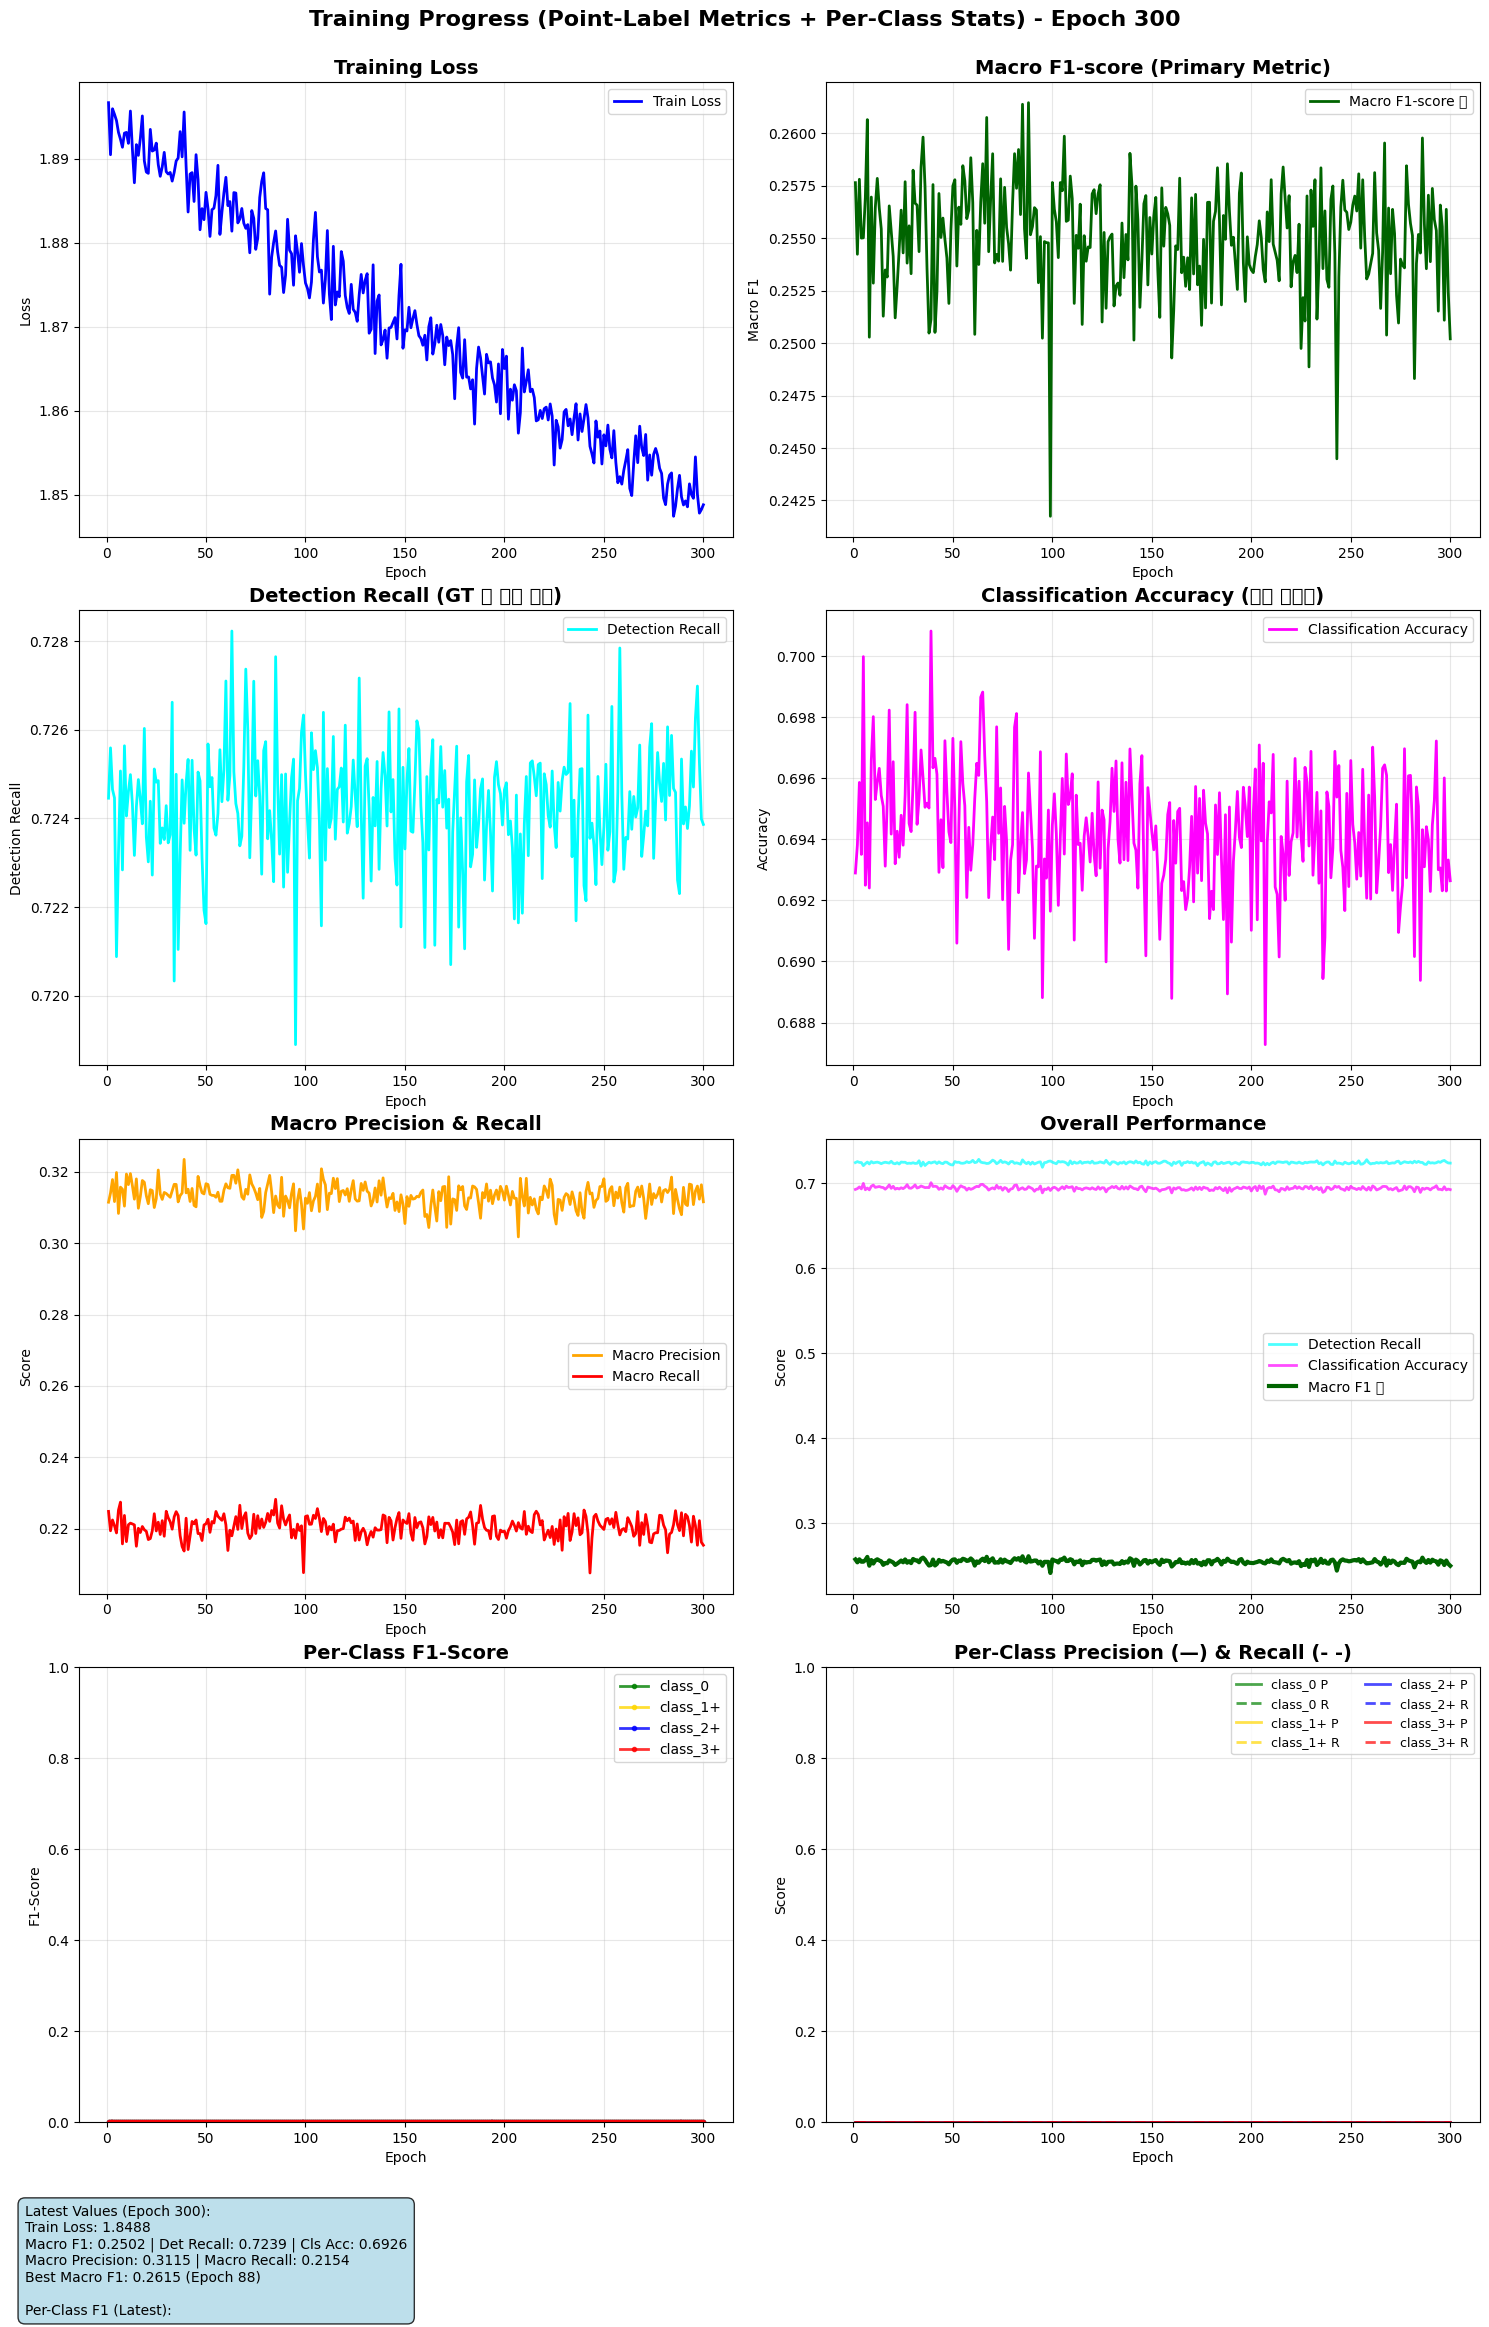


📊 Epoch 300 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_300.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_300.png


Epoch 301/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 301/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.631 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 301/10000 Results:
  Train Loss - Box: 0.6878, Cls: 0.6313, DFL: 0.5325, Total: 1.8516
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6945 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3164
  Macro Recall: 0.2176
  Macro F1-score: 0.2529 ⭐
  Overall Recall: 0.5023


Epoch 302/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 302/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 302/10000 Results:
  Train Loss - Box: 0.6851, Cls: 0.6282, DFL: 0.5323, Total: 1.8457
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6948 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3125
  Macro Recall: 0.2173
  Macro F1-score: 0.2523 ⭐
  Overall Recall: 0.5039


Epoch 303/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 303/10000 Results:
  Train Loss - Box: 0.6859, Cls: 0.6292, DFL: 0.5323, Total: 1.8474
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6912 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3092
  Macro Recall: 0.2180
  Macro F1-score: 0.2516 ⭐
  Overall Recall: 0.5008


Epoch 304/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.632 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 304/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.632 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 304/10000 Results:
  Train Loss - Box: 0.6874, Cls: 0.6316, DFL: 0.5324, Total: 1.8514
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6916 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3118
  Macro Recall: 0.2167
  Macro F1-score: 0.2515 ⭐
  Overall Recall: 0.5006


Epoch 305/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 305/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 305/10000 Results:
  Train Loss - Box: 0.6876, Cls: 0.6317, DFL: 0.5325, Total: 1.8518
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6928 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3121
  Macro Recall: 0.2188
  Macro F1-score: 0.2531 ⭐
  Overall Recall: 0.5018


Epoch 306/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 306/10000 | Memory: 33.16G | Box: 0.688 | Cls: 0.632 | DFL: 0.533: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 306/10000 Results:
  Train Loss - Box: 0.6877, Cls: 0.6316, DFL: 0.5325, Total: 1.8519
🎯 Point-Label Metrics:
  Detection Recall: 0.7216 (GT 중 찾은 비율)
  Classification Accuracy: 0.6880 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3122
  Macro Recall: 0.2213
  Macro F1-score: 0.2555 ⭐
  Overall Recall: 0.4965


Epoch 307/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.631 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 307/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.631 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 307/10000 Results:
  Train Loss - Box: 0.6871, Cls: 0.6310, DFL: 0.5325, Total: 1.8506
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6950 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3114
  Macro Recall: 0.2233
  Macro F1-score: 0.2576 ⭐
  Overall Recall: 0.5024


Epoch 308/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 308/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 308/10000 Results:
  Train Loss - Box: 0.6863, Cls: 0.6301, DFL: 0.5324, Total: 1.8488
🎯 Point-Label Metrics:
  Detection Recall: 0.7239 (GT 중 찾은 비율)
  Classification Accuracy: 0.6932 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3133
  Macro Recall: 0.2214
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5018


Epoch 309/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 309/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 309/10000 Results:
  Train Loss - Box: 0.6841, Cls: 0.6271, DFL: 0.5322, Total: 1.8434
🎯 Point-Label Metrics:
  Detection Recall: 0.7255 (GT 중 찾은 비율)
  Classification Accuracy: 0.6955 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3106
  Macro Recall: 0.2227
  Macro F1-score: 0.2555 ⭐
  Overall Recall: 0.5046


Epoch 310/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 310/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 310/10000 Results:
  Train Loss - Box: 0.6840, Cls: 0.6271, DFL: 0.5322, Total: 1.8434
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6935 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3092
  Macro Recall: 0.2192
  Macro F1-score: 0.2527 ⭐
  Overall Recall: 0.5013

📊 Epoch 310 - 검증 샘플 1/1:

📊 Epoch 310 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_310.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_310.png


Epoch 311/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 311/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 311/10000 Results:
  Train Loss - Box: 0.6857, Cls: 0.6291, DFL: 0.5324, Total: 1.8472
🎯 Point-Label Metrics:
  Detection Recall: 0.7224 (GT 중 찾은 비율)
  Classification Accuracy: 0.6914 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3132
  Macro Recall: 0.2172
  Macro F1-score: 0.2515 ⭐
  Overall Recall: 0.4995


Epoch 312/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.631 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 312/10000 Results:
  Train Loss - Box: 0.6872, Cls: 0.6315, DFL: 0.5325, Total: 1.8511
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6934 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3106
  Macro Recall: 0.2217
  Macro F1-score: 0.2556 ⭐
  Overall Recall: 0.5015


Epoch 313/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]
Epoch 313/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]



Epoch 313/10000 Results:
  Train Loss - Box: 0.6845, Cls: 0.6273, DFL: 0.5322, Total: 1.8440
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3117
  Macro Recall: 0.2174
  Macro F1-score: 0.2521 ⭐
  Overall Recall: 0.5024


Epoch 314/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 314/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 314/10000 Results:
  Train Loss - Box: 0.6854, Cls: 0.6285, DFL: 0.5324, Total: 1.8463
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6921 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3128
  Macro Recall: 0.2137
  Macro F1-score: 0.2490 ⭐
  Overall Recall: 0.5016


Epoch 315/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.631 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 315/10000 Results:
  Train Loss - Box: 0.6873, Cls: 0.6309, DFL: 0.5324, Total: 1.8507
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6966 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3133
  Macro Recall: 0.2228
  Macro F1-score: 0.2573 ⭐
  Overall Recall: 0.5047


Epoch 316/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 316/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 316/10000 Results:
  Train Loss - Box: 0.6849, Cls: 0.6284, DFL: 0.5323, Total: 1.8456
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6932 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3119
  Macro Recall: 0.2192
  Macro F1-score: 0.2543 ⭐
  Overall Recall: 0.5019


Epoch 317/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 317/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 317/10000 Results:
  Train Loss - Box: 0.6858, Cls: 0.6290, DFL: 0.5324, Total: 1.8471
🎯 Point-Label Metrics:
  Detection Recall: 0.7231 (GT 중 찾은 비율)
  Classification Accuracy: 0.6909 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3112
  Macro Recall: 0.2246
  Macro F1-score: 0.2579 ⭐
  Overall Recall: 0.4996


Epoch 318/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]
Epoch 318/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]



Epoch 318/10000 Results:
  Train Loss - Box: 0.6845, Cls: 0.6277, DFL: 0.5322, Total: 1.8445
🎯 Point-Label Metrics:
  Detection Recall: 0.7212 (GT 중 찾은 비율)
  Classification Accuracy: 0.6971 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3142
  Macro Recall: 0.2175
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5027


Epoch 319/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 319/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 319/10000 Results:
  Train Loss - Box: 0.6855, Cls: 0.6284, DFL: 0.5323, Total: 1.8461
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3147
  Macro Recall: 0.2227
  Macro F1-score: 0.2574 ⭐
  Overall Recall: 0.5021


Epoch 320/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 320/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 320/10000 Results:
  Train Loss - Box: 0.6854, Cls: 0.6282, DFL: 0.5323, Total: 1.8459
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6947 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3190
  Macro Recall: 0.2210
  Macro F1-score: 0.2564 ⭐
  Overall Recall: 0.5032

📊 Epoch 320 - 검증 샘플 1/1:

📊 Epoch 320 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_320.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_320.png


Epoch 321/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 321/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 321/10000 Results:
  Train Loss - Box: 0.6845, Cls: 0.6278, DFL: 0.5323, Total: 1.8446
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6955 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3146
  Macro Recall: 0.2216
  Macro F1-score: 0.2566 ⭐
  Overall Recall: 0.5040


Epoch 322/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 322/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 322/10000 Results:
  Train Loss - Box: 0.6843, Cls: 0.6277, DFL: 0.5323, Total: 1.8442
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6967 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3173
  Macro Recall: 0.2235
  Macro F1-score: 0.2587 ⭐
  Overall Recall: 0.5048


Epoch 323/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 323/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 323/10000 Results:
  Train Loss - Box: 0.6848, Cls: 0.6278, DFL: 0.5323, Total: 1.8448
🎯 Point-Label Metrics:
  Detection Recall: 0.7264 (GT 중 찾은 비율)
  Classification Accuracy: 0.6937 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3181
  Macro Recall: 0.2221
  Macro F1-score: 0.2571 ⭐
  Overall Recall: 0.5039


Epoch 324/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 324/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 324/10000 Results:
  Train Loss - Box: 0.6847, Cls: 0.6280, DFL: 0.5323, Total: 1.8450
🎯 Point-Label Metrics:
  Detection Recall: 0.7230 (GT 중 찾은 비율)
  Classification Accuracy: 0.6911 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3103
  Macro Recall: 0.2214
  Macro F1-score: 0.2547 ⭐
  Overall Recall: 0.4997


Epoch 325/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 325/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 325/10000 Results:
  Train Loss - Box: 0.6830, Cls: 0.6261, DFL: 0.5322, Total: 1.8413
🎯 Point-Label Metrics:
  Detection Recall: 0.7227 (GT 중 찾은 비율)
  Classification Accuracy: 0.6930 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3084
  Macro Recall: 0.2198
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5008


Epoch 326/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 326/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 326/10000 Results:
  Train Loss - Box: 0.6842, Cls: 0.6277, DFL: 0.5322, Total: 1.8441
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6914 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3121
  Macro Recall: 0.2231
  Macro F1-score: 0.2568 ⭐
  Overall Recall: 0.5001


Epoch 327/10000 | Memory: 33.16G | Box: 0.687 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 327/10000 Results:
  Train Loss - Box: 0.6868, Cls: 0.6304, DFL: 0.5324, Total: 1.8497
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6965 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3110
  Macro Recall: 0.2232
  Macro F1-score: 0.2566 ⭐
  Overall Recall: 0.5052


Epoch 328/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 328/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.630 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 328/10000 Results:
  Train Loss - Box: 0.6860, Cls: 0.6299, DFL: 0.5323, Total: 1.8482
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6911 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3127
  Macro Recall: 0.2191
  Macro F1-score: 0.2529 ⭐
  Overall Recall: 0.5000


Epoch 329/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 329/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 329/10000 Results:
  Train Loss - Box: 0.6833, Cls: 0.6271, DFL: 0.5322, Total: 1.8426
🎯 Point-Label Metrics:
  Detection Recall: 0.7227 (GT 중 찾은 비율)
  Classification Accuracy: 0.6966 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3177
  Macro Recall: 0.2214
  Macro F1-score: 0.2564 ⭐
  Overall Recall: 0.5034


Epoch 330/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 330/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 330/10000 Results:
  Train Loss - Box: 0.6852, Cls: 0.6284, DFL: 0.5323, Total: 1.8459
🎯 Point-Label Metrics:
  Detection Recall: 0.7264 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3078
  Macro Recall: 0.2242
  Macro F1-score: 0.2571 ⭐
  Overall Recall: 0.5041

📊 Epoch 330 - 검증 샘플 1/1:

📊 Epoch 330 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_330.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_330.png


Epoch 331/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 331/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 331/10000 Results:
  Train Loss - Box: 0.6843, Cls: 0.6276, DFL: 0.5322, Total: 1.8441
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6937 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3194
  Macro Recall: 0.2192
  Macro F1-score: 0.2554 ⭐
  Overall Recall: 0.5029


Epoch 332/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 332/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 332/10000 Results:
  Train Loss - Box: 0.6851, Cls: 0.6285, DFL: 0.5323, Total: 1.8459
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6947 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3119
  Macro Recall: 0.2202
  Macro F1-score: 0.2549 ⭐
  Overall Recall: 0.5022


Epoch 333/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 333/10000 Results:
  Train Loss - Box: 0.6838, Cls: 0.6275, DFL: 0.5322, Total: 1.8435
🎯 Point-Label Metrics:
  Detection Recall: 0.7241 (GT 중 찾은 비율)
  Classification Accuracy: 0.6915 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3044
  Macro Recall: 0.2174
  Macro F1-score: 0.2498 ⭐
  Overall Recall: 0.5007


Epoch 334/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 334/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 334/10000 Results:
  Train Loss - Box: 0.6851, Cls: 0.6285, DFL: 0.5323, Total: 1.8459
🎯 Point-Label Metrics:
  Detection Recall: 0.7251 (GT 중 찾은 비율)
  Classification Accuracy: 0.6930 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3105
  Macro Recall: 0.2232
  Macro F1-score: 0.2571 ⭐
  Overall Recall: 0.5025


Epoch 335/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 335/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 335/10000 Results:
  Train Loss - Box: 0.6829, Cls: 0.6261, DFL: 0.5321, Total: 1.8411
🎯 Point-Label Metrics:
  Detection Recall: 0.7217 (GT 중 찾은 비율)
  Classification Accuracy: 0.6915 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3121
  Macro Recall: 0.2211
  Macro F1-score: 0.2550 ⭐
  Overall Recall: 0.4991


Epoch 336/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 336/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 336/10000 Results:
  Train Loss - Box: 0.6833, Cls: 0.6264, DFL: 0.5322, Total: 1.8419
🎯 Point-Label Metrics:
  Detection Recall: 0.7255 (GT 중 찾은 비율)
  Classification Accuracy: 0.6929 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3129
  Macro Recall: 0.2197
  Macro F1-score: 0.2538 ⭐
  Overall Recall: 0.5027


Epoch 337/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 337/10000 Results:
  Train Loss - Box: 0.6844, Cls: 0.6278, DFL: 0.5322, Total: 1.8445
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6936 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3129
  Macro Recall: 0.2194
  Macro F1-score: 0.2542 ⭐
  Overall Recall: 0.5017


Epoch 338/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 338/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 338/10000 Results:
  Train Loss - Box: 0.6840, Cls: 0.6273, DFL: 0.5322, Total: 1.8434
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6934 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3120
  Macro Recall: 0.2206
  Macro F1-score: 0.2549 ⭐
  Overall Recall: 0.5025


Epoch 339/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]




Epoch 339/10000 Results:
  Train Loss - Box: 0.6852, Cls: 0.6282, DFL: 0.5323, Total: 1.8457
🎯 Point-Label Metrics:
  Detection Recall: 0.7227 (GT 중 찾은 비율)
  Classification Accuracy: 0.6950 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3170
  Macro Recall: 0.2189
  Macro F1-score: 0.2546 ⭐
  Overall Recall: 0.5023


Epoch 340/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 340/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 340/10000 Results:
  Train Loss - Box: 0.6845, Cls: 0.6281, DFL: 0.5322, Total: 1.8449
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6918 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3132
  Macro Recall: 0.2180
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5010

📊 Epoch 340 - 검증 샘플 1/1:

📊 Epoch 340 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_340.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_340.png


Epoch 341/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 341/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 341/10000 Results:
  Train Loss - Box: 0.6828, Cls: 0.6260, DFL: 0.5321, Total: 1.8409
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6953 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3131
  Macro Recall: 0.2218
  Macro F1-score: 0.2561 ⭐
  Overall Recall: 0.5036


Epoch 342/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 342/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 342/10000 Results:
  Train Loss - Box: 0.6828, Cls: 0.6258, DFL: 0.5321, Total: 1.8408
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6953 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3106
  Macro Recall: 0.2220
  Macro F1-score: 0.2562 ⭐
  Overall Recall: 0.5041


Epoch 343/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 343/10000 | Memory: 33.16G | Box: 0.686 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 343/10000 Results:
  Train Loss - Box: 0.6857, Cls: 0.6295, DFL: 0.5324, Total: 1.8476
🎯 Point-Label Metrics:
  Detection Recall: 0.7236 (GT 중 찾은 비율)
  Classification Accuracy: 0.6892 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3057
  Macro Recall: 0.2206
  Macro F1-score: 0.2523 ⭐
  Overall Recall: 0.4987


Epoch 344/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]




Epoch 344/10000 Results:
  Train Loss - Box: 0.6839, Cls: 0.6272, DFL: 0.5322, Total: 1.8433
🎯 Point-Label Metrics:
  Detection Recall: 0.7248 (GT 중 찾은 비율)
  Classification Accuracy: 0.6926 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3115
  Macro Recall: 0.2184
  Macro F1-score: 0.2524 ⭐
  Overall Recall: 0.5020


Epoch 345/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 345/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 345/10000 Results:
  Train Loss - Box: 0.6842, Cls: 0.6277, DFL: 0.5322, Total: 1.8441
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6956 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3141
  Macro Recall: 0.2225
  Macro F1-score: 0.2571 ⭐
  Overall Recall: 0.5031


Epoch 346/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 346/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 346/10000 Results:
  Train Loss - Box: 0.6844, Cls: 0.6275, DFL: 0.5322, Total: 1.8441
🎯 Point-Label Metrics:
  Detection Recall: 0.7260 (GT 중 찾은 비율)
  Classification Accuracy: 0.6972 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3161
  Macro Recall: 0.2172
  Macro F1-score: 0.2518 ⭐
  Overall Recall: 0.5062


Epoch 347/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 347/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 347/10000 Results:
  Train Loss - Box: 0.6834, Cls: 0.6264, DFL: 0.5322, Total: 1.8420
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6936 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3112
  Macro Recall: 0.2216
  Macro F1-score: 0.2558 ⭐
  Overall Recall: 0.5028


Epoch 348/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 348/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 348/10000 Results:
  Train Loss - Box: 0.6841, Cls: 0.6270, DFL: 0.5322, Total: 1.8433
🎯 Point-Label Metrics:
  Detection Recall: 0.7263 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3158
  Macro Recall: 0.2192
  Macro F1-score: 0.2547 ⭐
  Overall Recall: 0.5034


Epoch 349/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 349/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 349/10000 Results:
  Train Loss - Box: 0.6829, Cls: 0.6265, DFL: 0.5321, Total: 1.8415
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6921 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3062
  Macro Recall: 0.2216
  Macro F1-score: 0.2542 ⭐
  Overall Recall: 0.5010


Epoch 350/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 350/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 350/10000 Results:
  Train Loss - Box: 0.6821, Cls: 0.6250, DFL: 0.5321, Total: 1.8391
🎯 Point-Label Metrics:
  Detection Recall: 0.7257 (GT 중 찾은 비율)
  Classification Accuracy: 0.6959 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3064
  Macro Recall: 0.2226
  Macro F1-score: 0.2554 ⭐
  Overall Recall: 0.5050

📊 Epoch 350 - 검증 샘플 1/1:

📊 Epoch 350 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_350.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_350.png


Epoch 351/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 351/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 351/10000 Results:
  Train Loss - Box: 0.6839, Cls: 0.6274, DFL: 0.5322, Total: 1.8436
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6921 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3140
  Macro Recall: 0.2218
  Macro F1-score: 0.2559 ⭐
  Overall Recall: 0.5020


Epoch 352/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 352/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 352/10000 Results:
  Train Loss - Box: 0.6837, Cls: 0.6270, DFL: 0.5322, Total: 1.8428
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6957 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3119
  Macro Recall: 0.2207
  Macro F1-score: 0.2547 ⭐
  Overall Recall: 0.5038


Epoch 353/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 353/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 353/10000 Results:
  Train Loss - Box: 0.6851, Cls: 0.6293, DFL: 0.5323, Total: 1.8466
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6917 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3096
  Macro Recall: 0.2277
  Macro F1-score: 0.2600 ⭐
  Overall Recall: 0.5015


Epoch 354/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 354/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.629 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 354/10000 Results:
  Train Loss - Box: 0.6847, Cls: 0.6285, DFL: 0.5323, Total: 1.8455
🎯 Point-Label Metrics:
  Detection Recall: 0.7258 (GT 중 찾은 비율)
  Classification Accuracy: 0.6936 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3108
  Macro Recall: 0.2272
  Macro F1-score: 0.2598 ⭐
  Overall Recall: 0.5034


Epoch 355/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]




Epoch 355/10000 Results:
  Train Loss - Box: 0.6837, Cls: 0.6273, DFL: 0.5322, Total: 1.8432
🎯 Point-Label Metrics:
  Detection Recall: 0.7227 (GT 중 찾은 비율)
  Classification Accuracy: 0.6913 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3146
  Macro Recall: 0.2226
  Macro F1-score: 0.2569 ⭐
  Overall Recall: 0.4996


Epoch 356/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 356/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 356/10000 Results:
  Train Loss - Box: 0.6838, Cls: 0.6272, DFL: 0.5322, Total: 1.8432
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3118
  Macro Recall: 0.2186
  Macro F1-score: 0.2532 ⭐
  Overall Recall: 0.5027


Epoch 357/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:32<00:00,  4.62it/s]
Epoch 357/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:32<00:00,  4.62it/s]



Epoch 357/10000 Results:
  Train Loss - Box: 0.6829, Cls: 0.6256, DFL: 0.5322, Total: 1.8406
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6964 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3167
  Macro Recall: 0.2207
  Macro F1-score: 0.2564 ⭐
  Overall Recall: 0.5042


Epoch 358/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 358/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 358/10000 Results:
  Train Loss - Box: 0.6826, Cls: 0.6255, DFL: 0.5321, Total: 1.8402
🎯 Point-Label Metrics:
  Detection Recall: 0.7241 (GT 중 찾은 비율)
  Classification Accuracy: 0.6921 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3105
  Macro Recall: 0.2212
  Macro F1-score: 0.2550 ⭐
  Overall Recall: 0.5012


Epoch 359/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 359/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 359/10000 Results:
  Train Loss - Box: 0.6827, Cls: 0.6252, DFL: 0.5321, Total: 1.8400
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6953 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3124
  Macro Recall: 0.2204
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5043


Epoch 360/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 360/10000 Results:
  Train Loss - Box: 0.6830, Cls: 0.6264, DFL: 0.5321, Total: 1.8415
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6955 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3141
  Macro Recall: 0.2238
  Macro F1-score: 0.2582 ⭐
  Overall Recall: 0.5042

📊 Epoch 360 - 검증 샘플 1/1:

📊 Epoch 360 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_360.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_360.png


Epoch 361/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 361/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 361/10000 Results:
  Train Loss - Box: 0.6833, Cls: 0.6267, DFL: 0.5321, Total: 1.8422
🎯 Point-Label Metrics:
  Detection Recall: 0.7225 (GT 중 찾은 비율)
  Classification Accuracy: 0.6937 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3071
  Macro Recall: 0.2210
  Macro F1-score: 0.2536 ⭐
  Overall Recall: 0.5012


Epoch 362/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 362/10000 Results:
  Train Loss - Box: 0.6816, Cls: 0.6243, DFL: 0.5320, Total: 1.8379
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6959 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3092
  Macro Recall: 0.2193
  Macro F1-score: 0.2533 ⭐
  Overall Recall: 0.5047


Epoch 363/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 363/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 363/10000 Results:
  Train Loss - Box: 0.6824, Cls: 0.6257, DFL: 0.5321, Total: 1.8402
🎯 Point-Label Metrics:
  Detection Recall: 0.7239 (GT 중 찾은 비율)
  Classification Accuracy: 0.6940 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3115
  Macro Recall: 0.2201
  Macro F1-score: 0.2544 ⭐
  Overall Recall: 0.5024


Epoch 364/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 364/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 364/10000 Results:
  Train Loss - Box: 0.6835, Cls: 0.6271, DFL: 0.5322, Total: 1.8428
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6932 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3102
  Macro Recall: 0.2171
  Macro F1-score: 0.2517 ⭐
  Overall Recall: 0.5019


Epoch 365/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 365/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 365/10000 Results:
  Train Loss - Box: 0.6824, Cls: 0.6253, DFL: 0.5321, Total: 1.8398
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6918 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3134
  Macro Recall: 0.2202
  Macro F1-score: 0.2547 ⭐
  Overall Recall: 0.5014


Epoch 366/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 366/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 366/10000 Results:
  Train Loss - Box: 0.6819, Cls: 0.6248, DFL: 0.5321, Total: 1.8388
🎯 Point-Label Metrics:
  Detection Recall: 0.7209 (GT 중 찾은 비율)
  Classification Accuracy: 0.6929 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3036
  Macro Recall: 0.2218
  Macro F1-score: 0.2541 ⭐
  Overall Recall: 0.4995


Epoch 367/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 367/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 367/10000 Results:
  Train Loss - Box: 0.6823, Cls: 0.6258, DFL: 0.5321, Total: 1.8402
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6967 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3140
  Macro Recall: 0.2170
  Macro F1-score: 0.2523 ⭐
  Overall Recall: 0.5051


Epoch 368/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 368/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 368/10000 Results:
  Train Loss - Box: 0.6833, Cls: 0.6269, DFL: 0.5322, Total: 1.8423
🎯 Point-Label Metrics:
  Detection Recall: 0.7217 (GT 중 찾은 비율)
  Classification Accuracy: 0.6915 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3098
  Macro Recall: 0.2222
  Macro F1-score: 0.2561 ⭐
  Overall Recall: 0.4990


Epoch 369/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 369/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 369/10000 Results:
  Train Loss - Box: 0.6824, Cls: 0.6258, DFL: 0.5321, Total: 1.8403
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3039
  Macro Recall: 0.2223
  Macro F1-score: 0.2534 ⭐
  Overall Recall: 0.5014


Epoch 370/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 370/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 370/10000 Results:
  Train Loss - Box: 0.6821, Cls: 0.6251, DFL: 0.5320, Total: 1.8392
🎯 Point-Label Metrics:
  Detection Recall: 0.7231 (GT 중 찾은 비율)
  Classification Accuracy: 0.6916 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3096
  Macro Recall: 0.2193
  Macro F1-score: 0.2529 ⭐
  Overall Recall: 0.5001

📊 Epoch 370 - 검증 샘플 1/1:

📊 Epoch 370 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_370.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_370.png


Epoch 371/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 371/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 371/10000 Results:
  Train Loss - Box: 0.6829, Cls: 0.6262, DFL: 0.5321, Total: 1.8412
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3093
  Macro Recall: 0.2199
  Macro F1-score: 0.2531 ⭐
  Overall Recall: 0.5014


Epoch 372/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 372/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 372/10000 Results:
  Train Loss - Box: 0.6833, Cls: 0.6266, DFL: 0.5322, Total: 1.8421
🎯 Point-Label Metrics:
  Detection Recall: 0.7254 (GT 중 찾은 비율)
  Classification Accuracy: 0.6959 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3125
  Macro Recall: 0.2209
  Macro F1-score: 0.2553 ⭐
  Overall Recall: 0.5048


Epoch 373/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 373/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 373/10000 Results:
  Train Loss - Box: 0.6839, Cls: 0.6271, DFL: 0.5322, Total: 1.8432
🎯 Point-Label Metrics:
  Detection Recall: 0.7222 (GT 중 찾은 비율)
  Classification Accuracy: 0.6947 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3141
  Macro Recall: 0.2190
  Macro F1-score: 0.2549 ⭐
  Overall Recall: 0.5017


Epoch 374/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 374/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 374/10000 Results:
  Train Loss - Box: 0.6816, Cls: 0.6244, DFL: 0.5320, Total: 1.8380
🎯 Point-Label Metrics:
  Detection Recall: 0.7226 (GT 중 찾은 비율)
  Classification Accuracy: 0.6949 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3126
  Macro Recall: 0.2211
  Macro F1-score: 0.2554 ⭐
  Overall Recall: 0.5021


Epoch 375/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 375/10000 | Memory: 33.16G | Box: 0.685 | Cls: 0.628 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 375/10000 Results:
  Train Loss - Box: 0.6851, Cls: 0.6282, DFL: 0.5323, Total: 1.8455
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6921 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3091
  Macro Recall: 0.2199
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.5016


Epoch 376/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 376/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 376/10000 Results:
  Train Loss - Box: 0.6820, Cls: 0.6249, DFL: 0.5320, Total: 1.8389
🎯 Point-Label Metrics:
  Detection Recall: 0.7228 (GT 중 찾은 비율)
  Classification Accuracy: 0.6928 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3088
  Macro Recall: 0.2256
  Macro F1-score: 0.2579 ⭐
  Overall Recall: 0.5007


Epoch 377/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 377/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 377/10000 Results:
  Train Loss - Box: 0.6821, Cls: 0.6255, DFL: 0.5321, Total: 1.8397
🎯 Point-Label Metrics:
  Detection Recall: 0.7220 (GT 중 찾은 비율)
  Classification Accuracy: 0.6935 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3088
  Macro Recall: 0.2216
  Macro F1-score: 0.2550 ⭐
  Overall Recall: 0.5008


Epoch 378/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 378/10000 Results:
  Train Loss - Box: 0.6805, Cls: 0.6234, DFL: 0.5320, Total: 1.8359
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6954 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3137
  Macro Recall: 0.2199
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5027


Epoch 379/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 379/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 379/10000 Results:
  Train Loss - Box: 0.6806, Cls: 0.6237, DFL: 0.5320, Total: 1.8363
🎯 Point-Label Metrics:
  Detection Recall: 0.7228 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3114
  Macro Recall: 0.2196
  Macro F1-score: 0.2537 ⭐
  Overall Recall: 0.5010


Epoch 380/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 380/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 380/10000 Results:
  Train Loss - Box: 0.6833, Cls: 0.6264, DFL: 0.5321, Total: 1.8418
🎯 Point-Label Metrics:
  Detection Recall: 0.7258 (GT 중 찾은 비율)
  Classification Accuracy: 0.6942 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3133
  Macro Recall: 0.2195
  Macro F1-score: 0.2549 ⭐
  Overall Recall: 0.5038

📊 Epoch 380 - 검증 샘플 1/1:

📊 Epoch 380 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_380.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_380.png


Epoch 381/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 381/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 381/10000 Results:
  Train Loss - Box: 0.6809, Cls: 0.6239, DFL: 0.5320, Total: 1.8368
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6946 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3134
  Macro Recall: 0.2180
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.5031


Epoch 382/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 382/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 382/10000 Results:
  Train Loss - Box: 0.6818, Cls: 0.6246, DFL: 0.5320, Total: 1.8384
🎯 Point-Label Metrics:
  Detection Recall: 0.7227 (GT 중 찾은 비율)
  Classification Accuracy: 0.6932 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3141
  Macro Recall: 0.2187
  Macro F1-score: 0.2537 ⭐
  Overall Recall: 0.5010


Epoch 383/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 383/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 383/10000 Results:
  Train Loss - Box: 0.6804, Cls: 0.6234, DFL: 0.5320, Total: 1.8357
🎯 Point-Label Metrics:
  Detection Recall: 0.7260 (GT 중 찾은 비율)
  Classification Accuracy: 0.6963 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3162
  Macro Recall: 0.2206
  Macro F1-score: 0.2561 ⭐
  Overall Recall: 0.5055


Epoch 384/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 384/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 384/10000 Results:
  Train Loss - Box: 0.6816, Cls: 0.6249, DFL: 0.5320, Total: 1.8385
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6893 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3077
  Macro Recall: 0.2230
  Macro F1-score: 0.2555 ⭐
  Overall Recall: 0.4992


Epoch 385/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 385/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 385/10000 Results:
  Train Loss - Box: 0.6834, Cls: 0.6269, DFL: 0.5322, Total: 1.8425
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6918 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3117
  Macro Recall: 0.2224
  Macro F1-score: 0.2560 ⭐
  Overall Recall: 0.5013


Epoch 386/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 386/10000 Results:
  Train Loss - Box: 0.6827, Cls: 0.6260, DFL: 0.5321, Total: 1.8408
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6936 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3126
  Macro Recall: 0.2205
  Macro F1-score: 0.2556 ⭐
  Overall Recall: 0.5014


Epoch 387/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 387/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 387/10000 Results:
  Train Loss - Box: 0.6839, Cls: 0.6274, DFL: 0.5322, Total: 1.8434
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3117
  Macro Recall: 0.2218
  Macro F1-score: 0.2553 ⭐
  Overall Recall: 0.5027


Epoch 388/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 388/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 388/10000 Results:
  Train Loss - Box: 0.6817, Cls: 0.6250, DFL: 0.5321, Total: 1.8387
🎯 Point-Label Metrics:
  Detection Recall: 0.7232 (GT 중 찾은 비율)
  Classification Accuracy: 0.6915 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3084
  Macro Recall: 0.2217
  Macro F1-score: 0.2536 ⭐
  Overall Recall: 0.5001


Epoch 389/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 389/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 389/10000 Results:
  Train Loss - Box: 0.6832, Cls: 0.6265, DFL: 0.5321, Total: 1.8418
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6953 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3169
  Macro Recall: 0.2211
  Macro F1-score: 0.2564 ⭐
  Overall Recall: 0.5043


Epoch 390/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 390/10000 Results:
  Train Loss - Box: 0.6812, Cls: 0.6241, DFL: 0.5320, Total: 1.8373
🎯 Point-Label Metrics:
  Detection Recall: 0.7231 (GT 중 찾은 비율)
  Classification Accuracy: 0.6924 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3153
  Macro Recall: 0.2151
  Macro F1-score: 0.2509 ⭐
  Overall Recall: 0.5007

📊 Epoch 390 - 검증 샘플 1/1:

📊 Epoch 390 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_390.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_390.png


Epoch 391/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 391/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 391/10000 Results:
  Train Loss - Box: 0.6813, Cls: 0.6245, DFL: 0.5320, Total: 1.8378
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3080
  Macro Recall: 0.2207
  Macro F1-score: 0.2537 ⭐
  Overall Recall: 0.5018


Epoch 392/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 392/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 392/10000 Results:
  Train Loss - Box: 0.6792, Cls: 0.6226, DFL: 0.5319, Total: 1.8337
🎯 Point-Label Metrics:
  Detection Recall: 0.7208 (GT 중 찾은 비율)
  Classification Accuracy: 0.6873 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3033
  Macro Recall: 0.2262
  Macro F1-score: 0.2563 ⭐
  Overall Recall: 0.4955


Epoch 393/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 393/10000 | Memory: 33.16G | Box: 0.684 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 393/10000 Results:
  Train Loss - Box: 0.6838, Cls: 0.6271, DFL: 0.5322, Total: 1.8431
🎯 Point-Label Metrics:
  Detection Recall: 0.7241 (GT 중 찾은 비율)
  Classification Accuracy: 0.6928 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3179
  Macro Recall: 0.2204
  Macro F1-score: 0.2561 ⭐
  Overall Recall: 0.5017


Epoch 394/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 394/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 394/10000 Results:
  Train Loss - Box: 0.6819, Cls: 0.6251, DFL: 0.5320, Total: 1.8390
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3131
  Macro Recall: 0.2207
  Macro F1-score: 0.2553 ⭐
  Overall Recall: 0.5019


Epoch 395/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 395/10000 Results:
  Train Loss - Box: 0.6807, Cls: 0.6237, DFL: 0.5320, Total: 1.8364
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3166
  Macro Recall: 0.2201
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5026


Epoch 396/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 396/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 396/10000 Results:
  Train Loss - Box: 0.6828, Cls: 0.6259, DFL: 0.5321, Total: 1.8409
🎯 Point-Label Metrics:
  Detection Recall: 0.7232 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3104
  Macro Recall: 0.2191
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.5010


Epoch 397/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 397/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 397/10000 Results:
  Train Loss - Box: 0.6834, Cls: 0.6263, DFL: 0.5321, Total: 1.8418
🎯 Point-Label Metrics:
  Detection Recall: 0.7244 (GT 중 찾은 비율)
  Classification Accuracy: 0.6940 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3085
  Macro Recall: 0.2224
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5027


Epoch 398/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 398/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 398/10000 Results:
  Train Loss - Box: 0.6820, Cls: 0.6256, DFL: 0.5321, Total: 1.8397
🎯 Point-Label Metrics:
  Detection Recall: 0.7228 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3137
  Macro Recall: 0.2195
  Macro F1-score: 0.2542 ⭐
  Overall Recall: 0.5015


Epoch 399/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 399/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 399/10000 Results:
  Train Loss - Box: 0.6808, Cls: 0.6237, DFL: 0.5320, Total: 1.8365
🎯 Point-Label Metrics:
  Detection Recall: 0.7237 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3110
  Macro Recall: 0.2189
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5013


Epoch 400/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 400/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 400/10000 Results:
  Train Loss - Box: 0.6812, Cls: 0.6238, DFL: 0.5320, Total: 1.8369
🎯 Point-Label Metrics:
  Detection Recall: 0.7244 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3090
  Macro Recall: 0.2235
  Macro F1-score: 0.2563 ⭐
  Overall Recall: 0.5022

📊 Epoch 400 - 학습 진행 상황 그래프 생성 중...

📊 Epoch 400 - 학습 진행 상황 그래프 생성 중...
📈 학습 진행 그래프 저장: ../../model/Breast_ST_context/training_progress_epoch_400.png
📈 학습 진행 그래프 저장: ../../model/Breast_ST_context/training_progress_epoch_400.png


<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

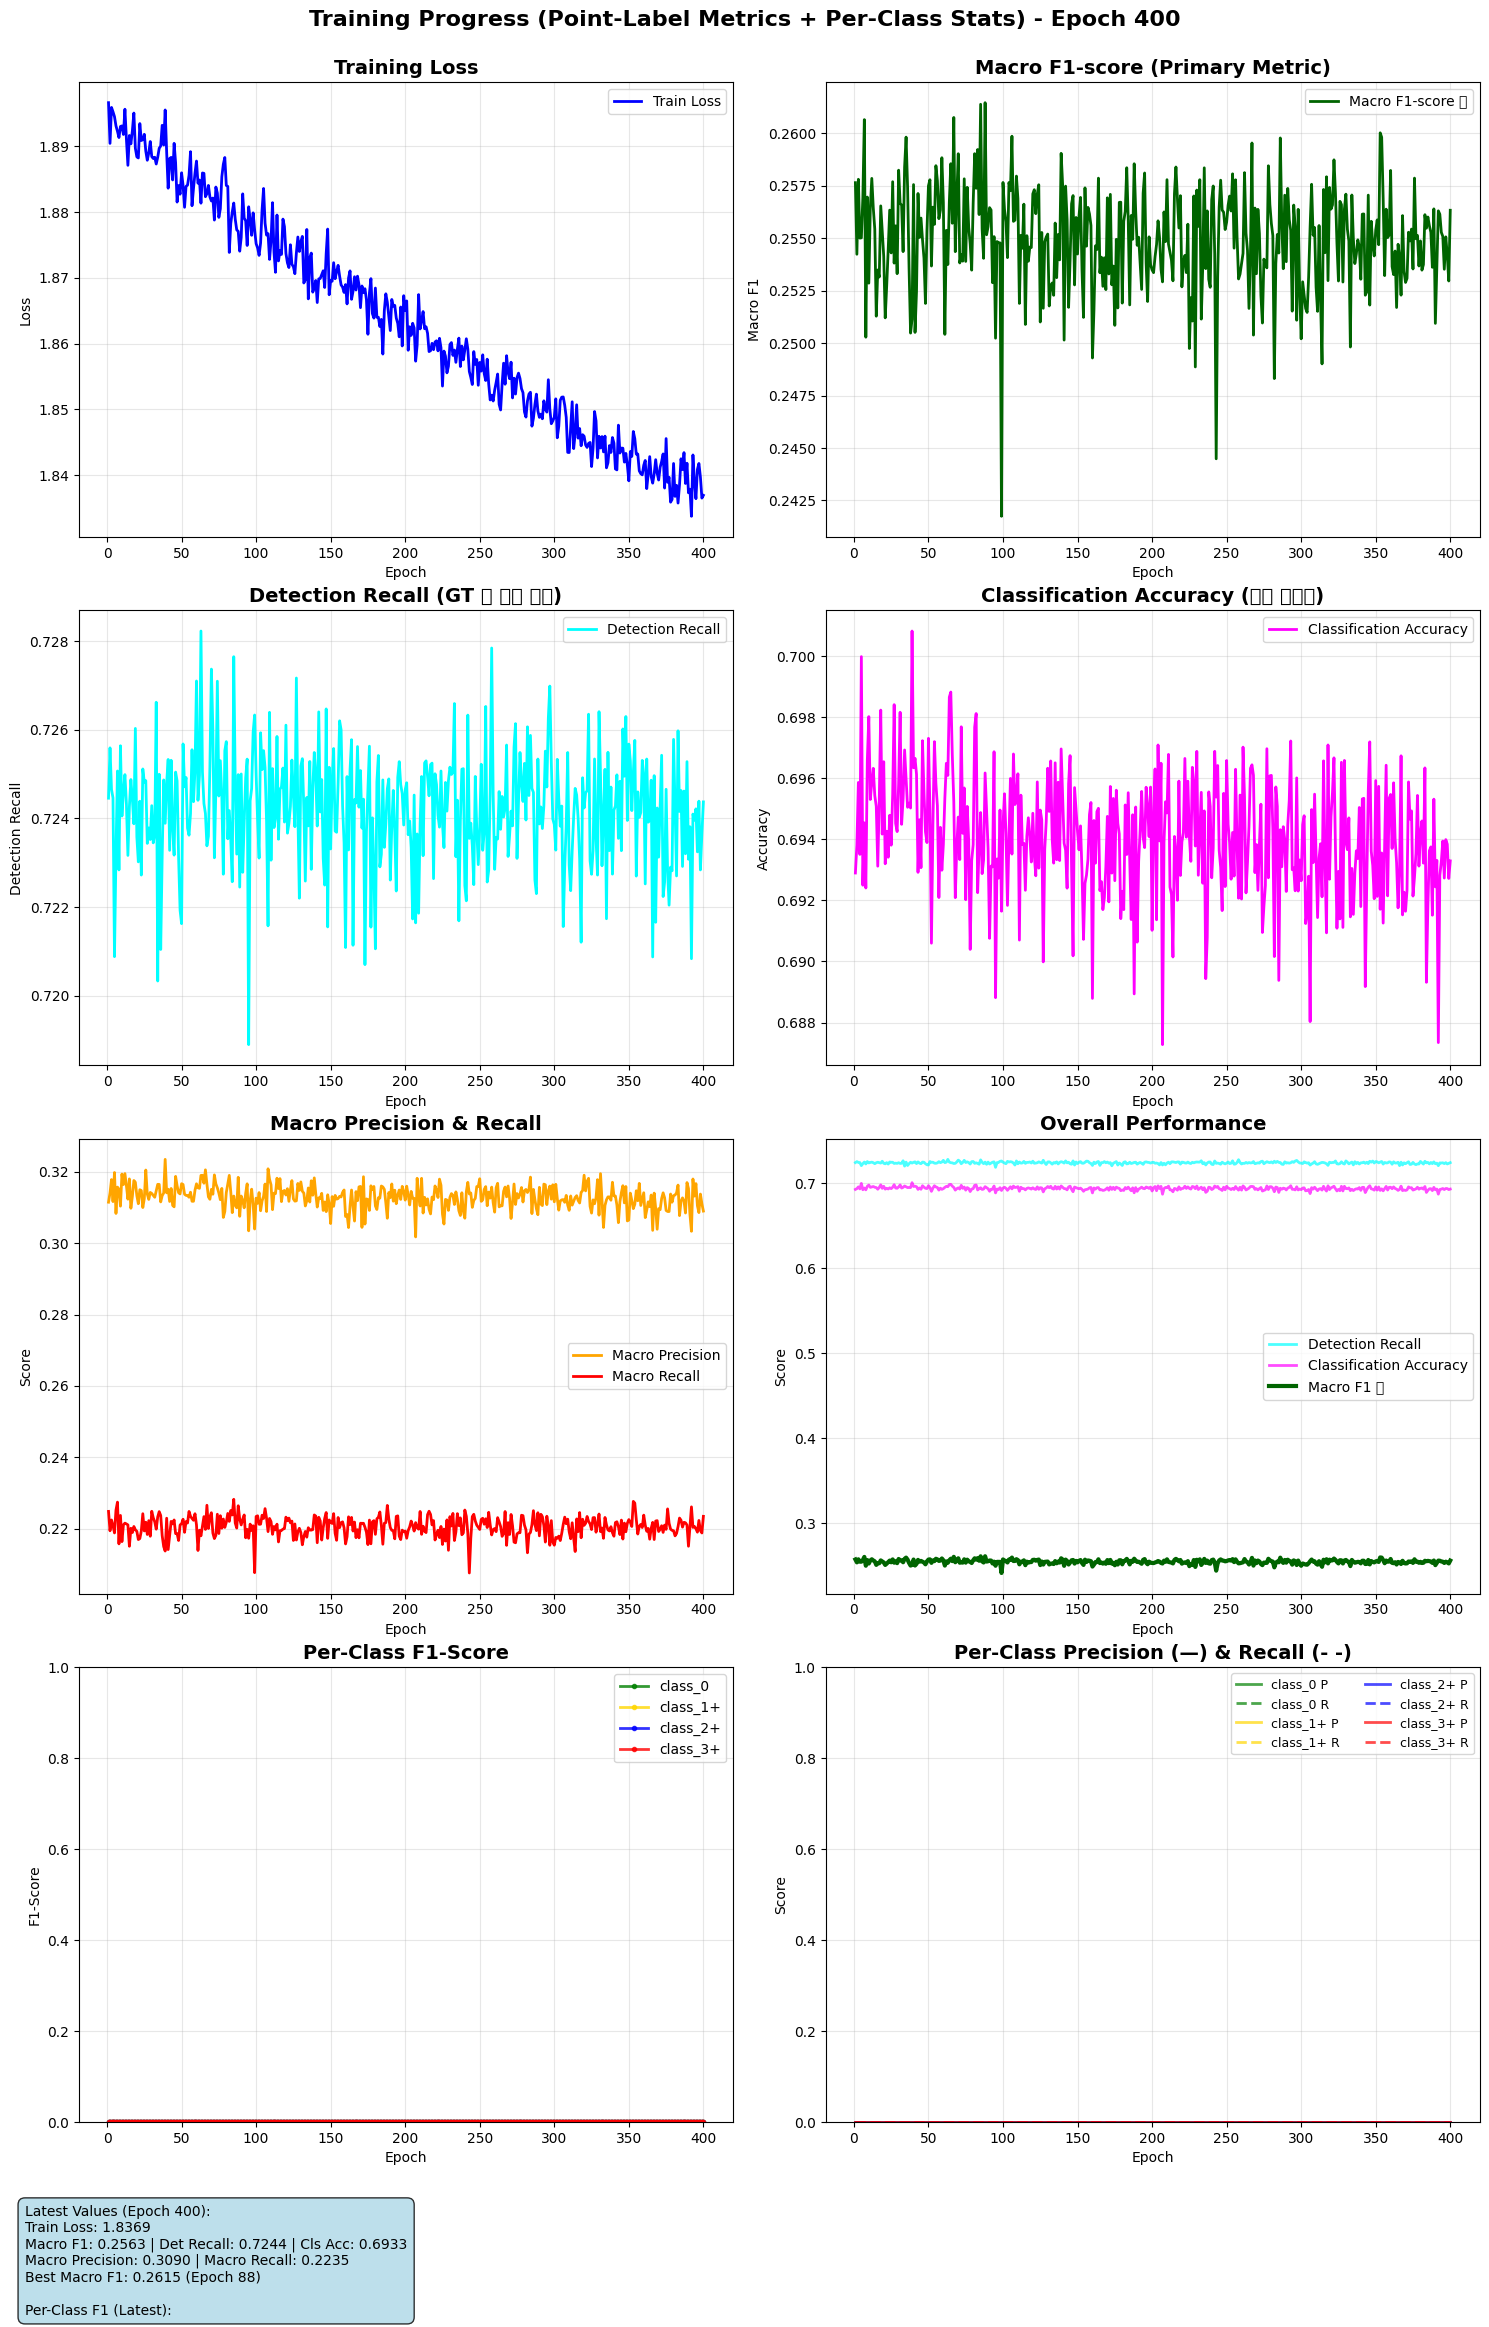


📊 Epoch 400 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_400.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_400.png


Epoch 401/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 401/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 401/10000 Results:
  Train Loss - Box: 0.6812, Cls: 0.6240, DFL: 0.5320, Total: 1.8372
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3115
  Macro Recall: 0.2180
  Macro F1-score: 0.2531 ⭐
  Overall Recall: 0.5012


Epoch 402/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 402/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.627 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 402/10000 Results:
  Train Loss - Box: 0.6826, Cls: 0.6266, DFL: 0.5321, Total: 1.8413
🎯 Point-Label Metrics:
  Detection Recall: 0.7227 (GT 중 찾은 비율)
  Classification Accuracy: 0.6943 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3109
  Macro Recall: 0.2213
  Macro F1-score: 0.2548 ⭐
  Overall Recall: 0.5018


Epoch 403/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 403/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 403/10000 Results:
  Train Loss - Box: 0.6794, Cls: 0.6220, DFL: 0.5319, Total: 1.8333
🎯 Point-Label Metrics:
  Detection Recall: 0.7236 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3121
  Macro Recall: 0.2242
  Macro F1-score: 0.2578 ⭐
  Overall Recall: 0.5017


Epoch 404/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 404/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 404/10000 Results:
  Train Loss - Box: 0.6792, Cls: 0.6219, DFL: 0.5318, Total: 1.8329
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6959 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3159
  Macro Recall: 0.2192
  Macro F1-score: 0.2543 ⭐
  Overall Recall: 0.5045


Epoch 405/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 405/10000 Results:
  Train Loss - Box: 0.6808, Cls: 0.6239, DFL: 0.5319, Total: 1.8366
🎯 Point-Label Metrics:
  Detection Recall: 0.7267 (GT 중 찾은 비율)
  Classification Accuracy: 0.6934 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3129
  Macro Recall: 0.2178
  Macro F1-score: 0.2523 ⭐
  Overall Recall: 0.5039


Epoch 406/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 406/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 406/10000 Results:
  Train Loss - Box: 0.6793, Cls: 0.6220, DFL: 0.5318, Total: 1.8331
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6941 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3100
  Macro Recall: 0.2204
  Macro F1-score: 0.2536 ⭐
  Overall Recall: 0.5029


Epoch 407/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 407/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 407/10000 Results:
  Train Loss - Box: 0.6804, Cls: 0.6235, DFL: 0.5319, Total: 1.8357
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6955 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3150
  Macro Recall: 0.2177
  Macro F1-score: 0.2533 ⭐
  Overall Recall: 0.5034


Epoch 408/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 408/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 408/10000 Results:
  Train Loss - Box: 0.6801, Cls: 0.6231, DFL: 0.5319, Total: 1.8351
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3146
  Macro Recall: 0.2217
  Macro F1-score: 0.2563 ⭐
  Overall Recall: 0.5019


Epoch 409/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 409/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 409/10000 Results:
  Train Loss - Box: 0.6813, Cls: 0.6246, DFL: 0.5320, Total: 1.8379
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6936 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3124
  Macro Recall: 0.2179
  Macro F1-score: 0.2515 ⭐
  Overall Recall: 0.5029


Epoch 410/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 410/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 410/10000 Results:
  Train Loss - Box: 0.6799, Cls: 0.6233, DFL: 0.5319, Total: 1.8352
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6952 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3146
  Macro Recall: 0.2227
  Macro F1-score: 0.2564 ⭐
  Overall Recall: 0.5038

📊 Epoch 410 - 검증 샘플 1/1:

📊 Epoch 410 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_410.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_410.png


Epoch 411/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 411/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 411/10000 Results:
  Train Loss - Box: 0.6814, Cls: 0.6243, DFL: 0.5320, Total: 1.8377
🎯 Point-Label Metrics:
  Detection Recall: 0.7251 (GT 중 찾은 비율)
  Classification Accuracy: 0.6935 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3089
  Macro Recall: 0.2210
  Macro F1-score: 0.2538 ⭐
  Overall Recall: 0.5029


Epoch 412/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 412/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 412/10000 Results:
  Train Loss - Box: 0.6796, Cls: 0.6226, DFL: 0.5318, Total: 1.8340
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6949 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3099
  Macro Recall: 0.2200
  Macro F1-score: 0.2537 ⭐
  Overall Recall: 0.5028


Epoch 413/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 413/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 413/10000 Results:
  Train Loss - Box: 0.6815, Cls: 0.6247, DFL: 0.5320, Total: 1.8381
🎯 Point-Label Metrics:
  Detection Recall: 0.7231 (GT 중 찾은 비율)
  Classification Accuracy: 0.6952 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3091
  Macro Recall: 0.2204
  Macro F1-score: 0.2541 ⭐
  Overall Recall: 0.5027


Epoch 414/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 414/10000 | Memory: 33.16G | Box: 0.683 | Cls: 0.626 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 414/10000 Results:
  Train Loss - Box: 0.6826, Cls: 0.6257, DFL: 0.5320, Total: 1.8402
🎯 Point-Label Metrics:
  Detection Recall: 0.7259 (GT 중 찾은 비율)
  Classification Accuracy: 0.6953 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3110
  Macro Recall: 0.2240
  Macro F1-score: 0.2577 ⭐
  Overall Recall: 0.5047


Epoch 415/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 415/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 415/10000 Results:
  Train Loss - Box: 0.6812, Cls: 0.6239, DFL: 0.5320, Total: 1.8371
🎯 Point-Label Metrics:
  Detection Recall: 0.7237 (GT 중 찾은 비율)
  Classification Accuracy: 0.6924 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3109
  Macro Recall: 0.2246
  Macro F1-score: 0.2572 ⭐
  Overall Recall: 0.5011


Epoch 416/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 416/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 416/10000 Results:
  Train Loss - Box: 0.6795, Cls: 0.6220, DFL: 0.5318, Total: 1.8334
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3097
  Macro Recall: 0.2214
  Macro F1-score: 0.2550 ⭐
  Overall Recall: 0.5018


Epoch 417/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 417/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 417/10000 Results:
  Train Loss - Box: 0.6809, Cls: 0.6246, DFL: 0.5320, Total: 1.8375
🎯 Point-Label Metrics:
  Detection Recall: 0.7257 (GT 중 찾은 비율)
  Classification Accuracy: 0.6940 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3153
  Macro Recall: 0.2188
  Macro F1-score: 0.2543 ⭐
  Overall Recall: 0.5037


Epoch 418/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 418/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 418/10000 Results:
  Train Loss - Box: 0.6795, Cls: 0.6228, DFL: 0.5319, Total: 1.8342
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6946 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3115
  Macro Recall: 0.2176
  Macro F1-score: 0.2525 ⭐
  Overall Recall: 0.5029


Epoch 419/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 419/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 419/10000 Results:
  Train Loss - Box: 0.6812, Cls: 0.6244, DFL: 0.5320, Total: 1.8377
🎯 Point-Label Metrics:
  Detection Recall: 0.7237 (GT 중 찾은 비율)
  Classification Accuracy: 0.6924 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3131
  Macro Recall: 0.2216
  Macro F1-score: 0.2559 ⭐
  Overall Recall: 0.5011


Epoch 420/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 420/10000 | Memory: 33.16G | Box: 0.682 | Cls: 0.625 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 420/10000 Results:
  Train Loss - Box: 0.6816, Cls: 0.6248, DFL: 0.5320, Total: 1.8384
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6899 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3100
  Macro Recall: 0.2243
  Macro F1-score: 0.2571 ⭐
  Overall Recall: 0.5000

📊 Epoch 420 - 검증 샘플 1/1:

📊 Epoch 420 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_420.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_420.png


Epoch 421/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 421/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 421/10000 Results:
  Train Loss - Box: 0.6807, Cls: 0.6241, DFL: 0.5320, Total: 1.8367
🎯 Point-Label Metrics:
  Detection Recall: 0.7248 (GT 중 찾은 비율)
  Classification Accuracy: 0.6918 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3130
  Macro Recall: 0.2127
  Macro F1-score: 0.2482 ⭐
  Overall Recall: 0.5014


Epoch 422/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 422/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 422/10000 Results:
  Train Loss - Box: 0.6812, Cls: 0.6243, DFL: 0.5320, Total: 1.8375
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6929 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3141
  Macro Recall: 0.2201
  Macro F1-score: 0.2549 ⭐
  Overall Recall: 0.5018


Epoch 423/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 423/10000 Results:
  Train Loss - Box: 0.6798, Cls: 0.6230, DFL: 0.5319, Total: 1.8347
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6932 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3107
  Macro Recall: 0.2218
  Macro F1-score: 0.2556 ⭐
  Overall Recall: 0.5011


Epoch 424/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:32<00:00,  4.62it/s]




Epoch 424/10000 Results:
  Train Loss - Box: 0.6810, Cls: 0.6243, DFL: 0.5319, Total: 1.8373
🎯 Point-Label Metrics:
  Detection Recall: 0.7244 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3086
  Macro Recall: 0.2223
  Macro F1-score: 0.2555 ⭐
  Overall Recall: 0.5026


Epoch 425/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 425/10000 Results:
  Train Loss - Box: 0.6788, Cls: 0.6217, DFL: 0.5318, Total: 1.8323
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3116
  Macro Recall: 0.2226
  Macro F1-score: 0.2565 ⭐
  Overall Recall: 0.5033


Epoch 426/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 426/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 426/10000 Results:
  Train Loss - Box: 0.6796, Cls: 0.6227, DFL: 0.5319, Total: 1.8342
🎯 Point-Label Metrics:
  Detection Recall: 0.7254 (GT 중 찾은 비율)
  Classification Accuracy: 0.6953 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3148
  Macro Recall: 0.2167
  Macro F1-score: 0.2523 ⭐
  Overall Recall: 0.5044


Epoch 427/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 427/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 427/10000 Results:
  Train Loss - Box: 0.6797, Cls: 0.6226, DFL: 0.5319, Total: 1.8342
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3145
  Macro Recall: 0.2178
  Macro F1-score: 0.2528 ⭐
  Overall Recall: 0.5021


Epoch 428/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 428/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 428/10000 Results:
  Train Loss - Box: 0.6812, Cls: 0.6242, DFL: 0.5320, Total: 1.8373
🎯 Point-Label Metrics:
  Detection Recall: 0.7227 (GT 중 찾은 비율)
  Classification Accuracy: 0.6908 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3073
  Macro Recall: 0.2201
  Macro F1-score: 0.2537 ⭐
  Overall Recall: 0.4993


Epoch 429/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 429/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 429/10000 Results:
  Train Loss - Box: 0.6787, Cls: 0.6212, DFL: 0.5318, Total: 1.8317
🎯 Point-Label Metrics:
  Detection Recall: 0.7241 (GT 중 찾은 비율)
  Classification Accuracy: 0.6916 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3128
  Macro Recall: 0.2196
  Macro F1-score: 0.2541 ⭐
  Overall Recall: 0.5008


Epoch 430/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 430/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 430/10000 Results:
  Train Loss - Box: 0.6782, Cls: 0.6209, DFL: 0.5318, Total: 1.8309
🎯 Point-Label Metrics:
  Detection Recall: 0.7237 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3112
  Macro Recall: 0.2125
  Macro F1-score: 0.2482 ⭐
  Overall Recall: 0.5010

📊 Epoch 430 - 검증 샘플 1/1:

📊 Epoch 430 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_430.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_430.png


Epoch 431/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 431/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 431/10000 Results:
  Train Loss - Box: 0.6810, Cls: 0.6242, DFL: 0.5319, Total: 1.8372
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3120
  Macro Recall: 0.2169
  Macro F1-score: 0.2523 ⭐
  Overall Recall: 0.5025


Epoch 432/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 432/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 432/10000 Results:
  Train Loss - Box: 0.6800, Cls: 0.6230, DFL: 0.5319, Total: 1.8349
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3117
  Macro Recall: 0.2220
  Macro F1-score: 0.2563 ⭐
  Overall Recall: 0.5019


Epoch 433/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 433/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 433/10000 Results:
  Train Loss - Box: 0.6775, Cls: 0.6203, DFL: 0.5318, Total: 1.8296
🎯 Point-Label Metrics:
  Detection Recall: 0.7230 (GT 중 찾은 비율)
  Classification Accuracy: 0.6948 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3089
  Macro Recall: 0.2233
  Macro F1-score: 0.2564 ⭐
  Overall Recall: 0.5024


Epoch 434/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 434/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 434/10000 Results:
  Train Loss - Box: 0.6801, Cls: 0.6230, DFL: 0.5319, Total: 1.8350
🎯 Point-Label Metrics:
  Detection Recall: 0.7252 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3058
  Macro Recall: 0.2181
  Macro F1-score: 0.2512 ⭐
  Overall Recall: 0.5032


Epoch 435/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 435/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 435/10000 Results:
  Train Loss - Box: 0.6782, Cls: 0.6212, DFL: 0.5318, Total: 1.8312
🎯 Point-Label Metrics:
  Detection Recall: 0.7255 (GT 중 찾은 비율)
  Classification Accuracy: 0.6918 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3081
  Macro Recall: 0.2202
  Macro F1-score: 0.2538 ⭐
  Overall Recall: 0.5019


Epoch 436/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 436/10000 Results:
  Train Loss - Box: 0.6783, Cls: 0.6213, DFL: 0.5318, Total: 1.8313
🎯 Point-Label Metrics:
  Detection Recall: 0.7252 (GT 중 찾은 비율)
  Classification Accuracy: 0.6930 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3103
  Macro Recall: 0.2214
  Macro F1-score: 0.2553 ⭐
  Overall Recall: 0.5026


Epoch 437/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 437/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 437/10000 Results:
  Train Loss - Box: 0.6790, Cls: 0.6222, DFL: 0.5318, Total: 1.8330
🎯 Point-Label Metrics:
  Detection Recall: 0.7237 (GT 중 찾은 비율)
  Classification Accuracy: 0.6929 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3068
  Macro Recall: 0.2179
  Macro F1-score: 0.2512 ⭐
  Overall Recall: 0.5015


Epoch 438/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 438/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 438/10000 Results:
  Train Loss - Box: 0.6799, Cls: 0.6238, DFL: 0.5319, Total: 1.8356
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6948 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3129
  Macro Recall: 0.2180
  Macro F1-score: 0.2531 ⭐
  Overall Recall: 0.5037


Epoch 439/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 439/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 439/10000 Results:
  Train Loss - Box: 0.6791, Cls: 0.6215, DFL: 0.5318, Total: 1.8324
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6928 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3125
  Macro Recall: 0.2203
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5018


Epoch 440/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 440/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 440/10000 Results:
  Train Loss - Box: 0.6770, Cls: 0.6203, DFL: 0.5318, Total: 1.8290
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3119
  Macro Recall: 0.2187
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5024

📊 Epoch 440 - 검증 샘플 1/1:

📊 Epoch 440 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_440.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_440.png


Epoch 441/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 441/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 441/10000 Results:
  Train Loss - Box: 0.6781, Cls: 0.6211, DFL: 0.5317, Total: 1.8310
🎯 Point-Label Metrics:
  Detection Recall: 0.7244 (GT 중 찾은 비율)
  Classification Accuracy: 0.6951 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3164
  Macro Recall: 0.2183
  Macro F1-score: 0.2541 ⭐
  Overall Recall: 0.5035


Epoch 442/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 442/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 442/10000 Results:
  Train Loss - Box: 0.6781, Cls: 0.6205, DFL: 0.5318, Total: 1.8303
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6944 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3099
  Macro Recall: 0.2201
  Macro F1-score: 0.2538 ⭐
  Overall Recall: 0.5024


Epoch 443/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 443/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 443/10000 Results:
  Train Loss - Box: 0.6799, Cls: 0.6233, DFL: 0.5319, Total: 1.8350
🎯 Point-Label Metrics:
  Detection Recall: 0.7222 (GT 중 찾은 비율)
  Classification Accuracy: 0.6912 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3064
  Macro Recall: 0.2190
  Macro F1-score: 0.2526 ⭐
  Overall Recall: 0.4992


Epoch 444/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 444/10000 Results:
  Train Loss - Box: 0.6763, Cls: 0.6190, DFL: 0.5316, Total: 1.8269
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6950 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3162
  Macro Recall: 0.2228
  Macro F1-score: 0.2580 ⭐
  Overall Recall: 0.5036


Epoch 445/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 445/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 445/10000 Results:
  Train Loss - Box: 0.6794, Cls: 0.6219, DFL: 0.5318, Total: 1.8331
🎯 Point-Label Metrics:
  Detection Recall: 0.7256 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3098
  Macro Recall: 0.2224
  Macro F1-score: 0.2552 ⭐
  Overall Recall: 0.5026


Epoch 446/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 446/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 446/10000 Results:
  Train Loss - Box: 0.6790, Cls: 0.6220, DFL: 0.5318, Total: 1.8327
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6956 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3131
  Macro Recall: 0.2148
  Macro F1-score: 0.2495 ⭐
  Overall Recall: 0.5043


Epoch 447/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 447/10000 Results:
  Train Loss - Box: 0.6793, Cls: 0.6219, DFL: 0.5318, Total: 1.8330
🎯 Point-Label Metrics:
  Detection Recall: 0.7254 (GT 중 찾은 비율)
  Classification Accuracy: 0.6975 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3113
  Macro Recall: 0.2183
  Macro F1-score: 0.2526 ⭐
  Overall Recall: 0.5060


Epoch 448/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 448/10000 Results:
  Train Loss - Box: 0.6785, Cls: 0.6209, DFL: 0.5318, Total: 1.8312
🎯 Point-Label Metrics:
  Detection Recall: 0.7221 (GT 중 찾은 비율)
  Classification Accuracy: 0.6919 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3101
  Macro Recall: 0.2202
  Macro F1-score: 0.2539 ⭐
  Overall Recall: 0.4996


Epoch 449/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 449/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 449/10000 Results:
  Train Loss - Box: 0.6784, Cls: 0.6209, DFL: 0.5318, Total: 1.8311
🎯 Point-Label Metrics:
  Detection Recall: 0.7252 (GT 중 찾은 비율)
  Classification Accuracy: 0.6919 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3061
  Macro Recall: 0.2164
  Macro F1-score: 0.2500 ⭐
  Overall Recall: 0.5018


Epoch 450/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 450/10000 | Memory: 33.16G | Box: 0.681 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 450/10000 Results:
  Train Loss - Box: 0.6806, Cls: 0.6240, DFL: 0.5319, Total: 1.8365
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6916 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3130
  Macro Recall: 0.2153
  Macro F1-score: 0.2505 ⭐
  Overall Recall: 0.5010

📊 Epoch 450 - 검증 샘플 1/1:

📊 Epoch 450 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_450.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_450.png


Epoch 451/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 451/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 451/10000 Results:
  Train Loss - Box: 0.6784, Cls: 0.6211, DFL: 0.5318, Total: 1.8313
🎯 Point-Label Metrics:
  Detection Recall: 0.7224 (GT 중 찾은 비율)
  Classification Accuracy: 0.6922 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3036
  Macro Recall: 0.2232
  Macro F1-score: 0.2543 ⭐
  Overall Recall: 0.5001


Epoch 452/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 452/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 452/10000 Results:
  Train Loss - Box: 0.6779, Cls: 0.6207, DFL: 0.5317, Total: 1.8303
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6955 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3100
  Macro Recall: 0.2166
  Macro F1-score: 0.2513 ⭐
  Overall Recall: 0.5028


Epoch 453/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 453/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 453/10000 Results:
  Train Loss - Box: 0.6786, Cls: 0.6213, DFL: 0.5318, Total: 1.8317
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6944 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3087
  Macro Recall: 0.2199
  Macro F1-score: 0.2533 ⭐
  Overall Recall: 0.5033


Epoch 454/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 454/10000 Results:
  Train Loss - Box: 0.6779, Cls: 0.6207, DFL: 0.5317, Total: 1.8304
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6952 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3125
  Macro Recall: 0.2210
  Macro F1-score: 0.2553 ⭐
  Overall Recall: 0.5031


Epoch 455/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 455/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 455/10000 Results:
  Train Loss - Box: 0.6782, Cls: 0.6210, DFL: 0.5318, Total: 1.8310
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6919 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3100
  Macro Recall: 0.2243
  Macro F1-score: 0.2575 ⭐
  Overall Recall: 0.5015


Epoch 456/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 456/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 456/10000 Results:
  Train Loss - Box: 0.6782, Cls: 0.6207, DFL: 0.5317, Total: 1.8306
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3127
  Macro Recall: 0.2240
  Macro F1-score: 0.2578 ⭐
  Overall Recall: 0.5020


Epoch 457/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 457/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 457/10000 Results:
  Train Loss - Box: 0.6774, Cls: 0.6206, DFL: 0.5317, Total: 1.8298
🎯 Point-Label Metrics:
  Detection Recall: 0.7256 (GT 중 찾은 비율)
  Classification Accuracy: 0.6930 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3085
  Macro Recall: 0.2213
  Macro F1-score: 0.2549 ⭐
  Overall Recall: 0.5028


Epoch 458/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 458/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.624 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 458/10000 Results:
  Train Loss - Box: 0.6805, Cls: 0.6235, DFL: 0.5319, Total: 1.8359
🎯 Point-Label Metrics:
  Detection Recall: 0.7239 (GT 중 찾은 비율)
  Classification Accuracy: 0.6929 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3071
  Macro Recall: 0.2229
  Macro F1-score: 0.2563 ⭐
  Overall Recall: 0.5016


Epoch 459/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 459/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 459/10000 Results:
  Train Loss - Box: 0.6775, Cls: 0.6200, DFL: 0.5317, Total: 1.8292
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3086
  Macro Recall: 0.2251
  Macro F1-score: 0.2582 ⭐
  Overall Recall: 0.5020


Epoch 460/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 460/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 460/10000 Results:
  Train Loss - Box: 0.6774, Cls: 0.6200, DFL: 0.5317, Total: 1.8291
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6935 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3175
  Macro Recall: 0.2176
  Macro F1-score: 0.2539 ⭐
  Overall Recall: 0.5021

📊 Epoch 460 - 검증 샘플 1/1:

📊 Epoch 460 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_460.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_460.png


Epoch 461/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 461/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 461/10000 Results:
  Train Loss - Box: 0.6798, Cls: 0.6226, DFL: 0.5319, Total: 1.8343
🎯 Point-Label Metrics:
  Detection Recall: 0.7236 (GT 중 찾은 비율)
  Classification Accuracy: 0.6926 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3093
  Macro Recall: 0.2237
  Macro F1-score: 0.2560 ⭐
  Overall Recall: 0.5012


Epoch 462/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]




Epoch 462/10000 Results:
  Train Loss - Box: 0.6792, Cls: 0.6225, DFL: 0.5318, Total: 1.8335
🎯 Point-Label Metrics:
  Detection Recall: 0.7265 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3127
  Macro Recall: 0.2184
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5035


Epoch 463/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 463/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 463/10000 Results:
  Train Loss - Box: 0.6759, Cls: 0.6184, DFL: 0.5316, Total: 1.8259
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6935 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3153
  Macro Recall: 0.2224
  Macro F1-score: 0.2571 ⭐
  Overall Recall: 0.5017


Epoch 464/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 464/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 464/10000 Results:
  Train Loss - Box: 0.6773, Cls: 0.6200, DFL: 0.5317, Total: 1.8289
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6940 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3092
  Macro Recall: 0.2201
  Macro F1-score: 0.2536 ⭐
  Overall Recall: 0.5021


Epoch 465/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 465/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 465/10000 Results:
  Train Loss - Box: 0.6781, Cls: 0.6212, DFL: 0.5317, Total: 1.8311
🎯 Point-Label Metrics:
  Detection Recall: 0.7214 (GT 중 찾은 비율)
  Classification Accuracy: 0.6930 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3055
  Macro Recall: 0.2161
  Macro F1-score: 0.2494 ⭐
  Overall Recall: 0.4999


Epoch 466/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]
Epoch 466/10000 | Memory: 33.16G | Box: 0.680 | Cls: 0.623 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.64it/s]



Epoch 466/10000 Results:
  Train Loss - Box: 0.6800, Cls: 0.6232, DFL: 0.5319, Total: 1.8350
🎯 Point-Label Metrics:
  Detection Recall: 0.7230 (GT 중 찾은 비율)
  Classification Accuracy: 0.6925 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3113
  Macro Recall: 0.2233
  Macro F1-score: 0.2570 ⭐
  Overall Recall: 0.5007


Epoch 467/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 467/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 467/10000 Results:
  Train Loss - Box: 0.6780, Cls: 0.6215, DFL: 0.5317, Total: 1.8312
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6937 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3138
  Macro Recall: 0.2193
  Macro F1-score: 0.2545 ⭐
  Overall Recall: 0.5027


Epoch 468/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]




Epoch 468/10000 Results:
  Train Loss - Box: 0.6790, Cls: 0.6217, DFL: 0.5317, Total: 1.8325
🎯 Point-Label Metrics:
  Detection Recall: 0.7244 (GT 중 찾은 비율)
  Classification Accuracy: 0.6920 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3093
  Macro Recall: 0.2195
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5013


Epoch 469/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 469/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 469/10000 Results:
  Train Loss - Box: 0.6763, Cls: 0.6195, DFL: 0.5317, Total: 1.8274
🎯 Point-Label Metrics:
  Detection Recall: 0.7239 (GT 중 찾은 비율)
  Classification Accuracy: 0.6934 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3112
  Macro Recall: 0.2182
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5020


Epoch 470/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 470/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 470/10000 Results:
  Train Loss - Box: 0.6767, Cls: 0.6197, DFL: 0.5317, Total: 1.8280
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6936 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3130
  Macro Recall: 0.2230
  Macro F1-score: 0.2567 ⭐
  Overall Recall: 0.5022

📊 Epoch 470 - 검증 샘플 1/1:

📊 Epoch 470 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_470.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_470.png


Epoch 471/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 471/10000 | Memory: 33.16G | Box: 0.679 | Cls: 0.622 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 471/10000 Results:
  Train Loss - Box: 0.6790, Cls: 0.6216, DFL: 0.5318, Total: 1.8324
🎯 Point-Label Metrics:
  Detection Recall: 0.7225 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3118
  Macro Recall: 0.2198
  Macro F1-score: 0.2542 ⭐
  Overall Recall: 0.5005


Epoch 472/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 472/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 472/10000 Results:
  Train Loss - Box: 0.6772, Cls: 0.6203, DFL: 0.5317, Total: 1.8292
🎯 Point-Label Metrics:
  Detection Recall: 0.7234 (GT 중 찾은 비율)
  Classification Accuracy: 0.6976 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3137
  Macro Recall: 0.2143
  Macro F1-score: 0.2495 ⭐
  Overall Recall: 0.5046


Epoch 473/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 473/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 473/10000 Results:
  Train Loss - Box: 0.6783, Cls: 0.6208, DFL: 0.5318, Total: 1.8309
🎯 Point-Label Metrics:
  Detection Recall: 0.7236 (GT 중 찾은 비율)
  Classification Accuracy: 0.6943 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3093
  Macro Recall: 0.2180
  Macro F1-score: 0.2517 ⭐
  Overall Recall: 0.5023


Epoch 474/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 474/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 474/10000 Results:
  Train Loss - Box: 0.6764, Cls: 0.6189, DFL: 0.5316, Total: 1.8269
🎯 Point-Label Metrics:
  Detection Recall: 0.7262 (GT 중 찾은 비율)
  Classification Accuracy: 0.6943 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3122
  Macro Recall: 0.2203
  Macro F1-score: 0.2546 ⭐
  Overall Recall: 0.5042


Epoch 475/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:32<00:00,  4.59it/s]
Epoch 475/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:32<00:00,  4.59it/s]



Epoch 475/10000 Results:
  Train Loss - Box: 0.6766, Cls: 0.6191, DFL: 0.5316, Total: 1.8273
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6918 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3060
  Macro Recall: 0.2246
  Macro F1-score: 0.2564 ⭐
  Overall Recall: 0.5004


Epoch 476/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]
Epoch 476/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]



Epoch 476/10000 Results:
  Train Loss - Box: 0.6773, Cls: 0.6206, DFL: 0.5317, Total: 1.8295
🎯 Point-Label Metrics:
  Detection Recall: 0.7248 (GT 중 찾은 비율)
  Classification Accuracy: 0.6941 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3113
  Macro Recall: 0.2153
  Macro F1-score: 0.2503 ⭐
  Overall Recall: 0.5031


Epoch 477/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 477/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 477/10000 Results:
  Train Loss - Box: 0.6772, Cls: 0.6207, DFL: 0.5317, Total: 1.8297
🎯 Point-Label Metrics:
  Detection Recall: 0.7248 (GT 중 찾은 비율)
  Classification Accuracy: 0.6919 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3096
  Macro Recall: 0.2222
  Macro F1-score: 0.2549 ⭐
  Overall Recall: 0.5015


Epoch 478/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]
Epoch 478/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]



Epoch 478/10000 Results:
  Train Loss - Box: 0.6767, Cls: 0.6194, DFL: 0.5317, Total: 1.8278
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6959 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3155
  Macro Recall: 0.2143
  Macro F1-score: 0.2509 ⭐
  Overall Recall: 0.5044


Epoch 479/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 479/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 479/10000 Results:
  Train Loss - Box: 0.6760, Cls: 0.6185, DFL: 0.5316, Total: 1.8262
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6913 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3074
  Macro Recall: 0.2203
  Macro F1-score: 0.2534 ⭐
  Overall Recall: 0.5008


Epoch 480/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 480/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 480/10000 Results:
  Train Loss - Box: 0.6777, Cls: 0.6203, DFL: 0.5317, Total: 1.8297
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6942 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3120
  Macro Recall: 0.2185
  Macro F1-score: 0.2531 ⭐
  Overall Recall: 0.5021

📊 Epoch 480 - 검증 샘플 1/1:

📊 Epoch 480 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_480.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_480.png


Epoch 481/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 481/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 481/10000 Results:
  Train Loss - Box: 0.6772, Cls: 0.6200, DFL: 0.5317, Total: 1.8289
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6885 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3094
  Macro Recall: 0.2201
  Macro F1-score: 0.2539 ⭐
  Overall Recall: 0.4980


Epoch 482/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]




Epoch 482/10000 Results:
  Train Loss - Box: 0.6774, Cls: 0.6205, DFL: 0.5317, Total: 1.8296
🎯 Point-Label Metrics:
  Detection Recall: 0.7236 (GT 중 찾은 비율)
  Classification Accuracy: 0.6908 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3125
  Macro Recall: 0.2184
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.4999


Epoch 483/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]




Epoch 483/10000 Results:
  Train Loss - Box: 0.6763, Cls: 0.6186, DFL: 0.5316, Total: 1.8265
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6904 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3126
  Macro Recall: 0.2188
  Macro F1-score: 0.2521 ⭐
  Overall Recall: 0.5002


Epoch 484/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 484/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 484/10000 Results:
  Train Loss - Box: 0.6760, Cls: 0.6183, DFL: 0.5315, Total: 1.8258
🎯 Point-Label Metrics:
  Detection Recall: 0.7223 (GT 중 찾은 비율)
  Classification Accuracy: 0.6935 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3105
  Macro Recall: 0.2216
  Macro F1-score: 0.2553 ⭐
  Overall Recall: 0.5009


Epoch 485/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]
Epoch 485/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]



Epoch 485/10000 Results:
  Train Loss - Box: 0.6767, Cls: 0.6189, DFL: 0.5316, Total: 1.8271
🎯 Point-Label Metrics:
  Detection Recall: 0.7255 (GT 중 찾은 비율)
  Classification Accuracy: 0.6952 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3134
  Macro Recall: 0.2179
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5043


Epoch 486/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:32<00:00,  4.60it/s]
Epoch 486/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:32<00:00,  4.60it/s]



Epoch 486/10000 Results:
  Train Loss - Box: 0.6779, Cls: 0.6204, DFL: 0.5317, Total: 1.8300
🎯 Point-Label Metrics:
  Detection Recall: 0.7241 (GT 중 찾은 비율)
  Classification Accuracy: 0.6941 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3116
  Macro Recall: 0.2204
  Macro F1-score: 0.2549 ⭐
  Overall Recall: 0.5026


Epoch 487/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:32<00:00,  4.60it/s]
Epoch 487/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:32<00:00,  4.60it/s]



Epoch 487/10000 Results:
  Train Loss - Box: 0.6775, Cls: 0.6203, DFL: 0.5317, Total: 1.8294
🎯 Point-Label Metrics:
  Detection Recall: 0.7258 (GT 중 찾은 비율)
  Classification Accuracy: 0.6904 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3162
  Macro Recall: 0.2259
  Macro F1-score: 0.2597 ⭐
  Overall Recall: 0.5011


Epoch 488/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 488/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 488/10000 Results:
  Train Loss - Box: 0.6774, Cls: 0.6201, DFL: 0.5317, Total: 1.8291
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6917 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3090
  Macro Recall: 0.2191
  Macro F1-score: 0.2530 ⭐
  Overall Recall: 0.5010


Epoch 489/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 489/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 489/10000 Results:
  Train Loss - Box: 0.6755, Cls: 0.6177, DFL: 0.5315, Total: 1.8248
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6942 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3117
  Macro Recall: 0.2189
  Macro F1-score: 0.2536 ⭐
  Overall Recall: 0.5031


Epoch 490/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 490/10000 Results:
  Train Loss - Box: 0.6734, Cls: 0.6157, DFL: 0.5314, Total: 1.8205
🎯 Point-Label Metrics:
  Detection Recall: 0.7231 (GT 중 찾은 비율)
  Classification Accuracy: 0.6895 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3094
  Macro Recall: 0.2213
  Macro F1-score: 0.2548 ⭐
  Overall Recall: 0.4985

📊 Epoch 490 - 검증 샘플 1/1:

📊 Epoch 490 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_490.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_490.png


Epoch 491/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]
Epoch 491/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]



Epoch 491/10000 Results:
  Train Loss - Box: 0.6743, Cls: 0.6170, DFL: 0.5315, Total: 1.8229
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3156
  Macro Recall: 0.2209
  Macro F1-score: 0.2561 ⭐
  Overall Recall: 0.5020


Epoch 492/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.617 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 492/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.617 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 492/10000 Results:
  Train Loss - Box: 0.6752, Cls: 0.6173, DFL: 0.5315, Total: 1.8240
🎯 Point-Label Metrics:
  Detection Recall: 0.7220 (GT 중 찾은 비율)
  Classification Accuracy: 0.6949 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3106
  Macro Recall: 0.2201
  Macro F1-score: 0.2534 ⭐
  Overall Recall: 0.5017


Epoch 493/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 493/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 493/10000 Results:
  Train Loss - Box: 0.6782, Cls: 0.6211, DFL: 0.5317, Total: 1.8310
🎯 Point-Label Metrics:
  Detection Recall: 0.7265 (GT 중 찾은 비율)
  Classification Accuracy: 0.6925 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3090
  Macro Recall: 0.2213
  Macro F1-score: 0.2549 ⭐
  Overall Recall: 0.5031


Epoch 494/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 494/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 494/10000 Results:
  Train Loss - Box: 0.6766, Cls: 0.6192, DFL: 0.5316, Total: 1.8275
🎯 Point-Label Metrics:
  Detection Recall: 0.7239 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3059
  Macro Recall: 0.2198
  Macro F1-score: 0.2526 ⭐
  Overall Recall: 0.5011


Epoch 495/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 495/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 495/10000 Results:
  Train Loss - Box: 0.6754, Cls: 0.6187, DFL: 0.5316, Total: 1.8256
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6969 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3159
  Macro Recall: 0.2160
  Macro F1-score: 0.2518 ⭐
  Overall Recall: 0.5048


Epoch 496/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]




Epoch 496/10000 Results:
  Train Loss - Box: 0.6759, Cls: 0.6187, DFL: 0.5316, Total: 1.8262
🎯 Point-Label Metrics:
  Detection Recall: 0.7251 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3155
  Macro Recall: 0.2228
  Macro F1-score: 0.2577 ⭐
  Overall Recall: 0.5031


Epoch 497/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 497/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 497/10000 Results:
  Train Loss - Box: 0.6757, Cls: 0.6183, DFL: 0.5316, Total: 1.8256
🎯 Point-Label Metrics:
  Detection Recall: 0.7241 (GT 중 찾은 비율)
  Classification Accuracy: 0.6932 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3131
  Macro Recall: 0.2194
  Macro F1-score: 0.2543 ⭐
  Overall Recall: 0.5020


Epoch 498/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 498/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 498/10000 Results:
  Train Loss - Box: 0.6760, Cls: 0.6190, DFL: 0.5316, Total: 1.8266
🎯 Point-Label Metrics:
  Detection Recall: 0.7260 (GT 중 찾은 비율)
  Classification Accuracy: 0.6930 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3130
  Macro Recall: 0.2172
  Macro F1-score: 0.2526 ⭐
  Overall Recall: 0.5031


Epoch 499/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 499/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 499/10000 Results:
  Train Loss - Box: 0.6770, Cls: 0.6201, DFL: 0.5316, Total: 1.8288
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6937 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3155
  Macro Recall: 0.2208
  Macro F1-score: 0.2560 ⭐
  Overall Recall: 0.5023


Epoch 500/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]




Epoch 500/10000 Results:
  Train Loss - Box: 0.6767, Cls: 0.6199, DFL: 0.5317, Total: 1.8283
🎯 Point-Label Metrics:
  Detection Recall: 0.7224 (GT 중 찾은 비율)
  Classification Accuracy: 0.6910 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3067
  Macro Recall: 0.2147
  Macro F1-score: 0.2493 ⭐
  Overall Recall: 0.4992

📊 Epoch 500 - 학습 진행 상황 그래프 생성 중...

📊 Epoch 500 - 학습 진행 상황 그래프 생성 중...
📈 학습 진행 그래프 저장: ../../model/Breast_ST_context/training_progress_epoch_500.png
📈 학습 진행 그래프 저장: ../../model/Breast_ST_context/training_progress_epoch_500.png


<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

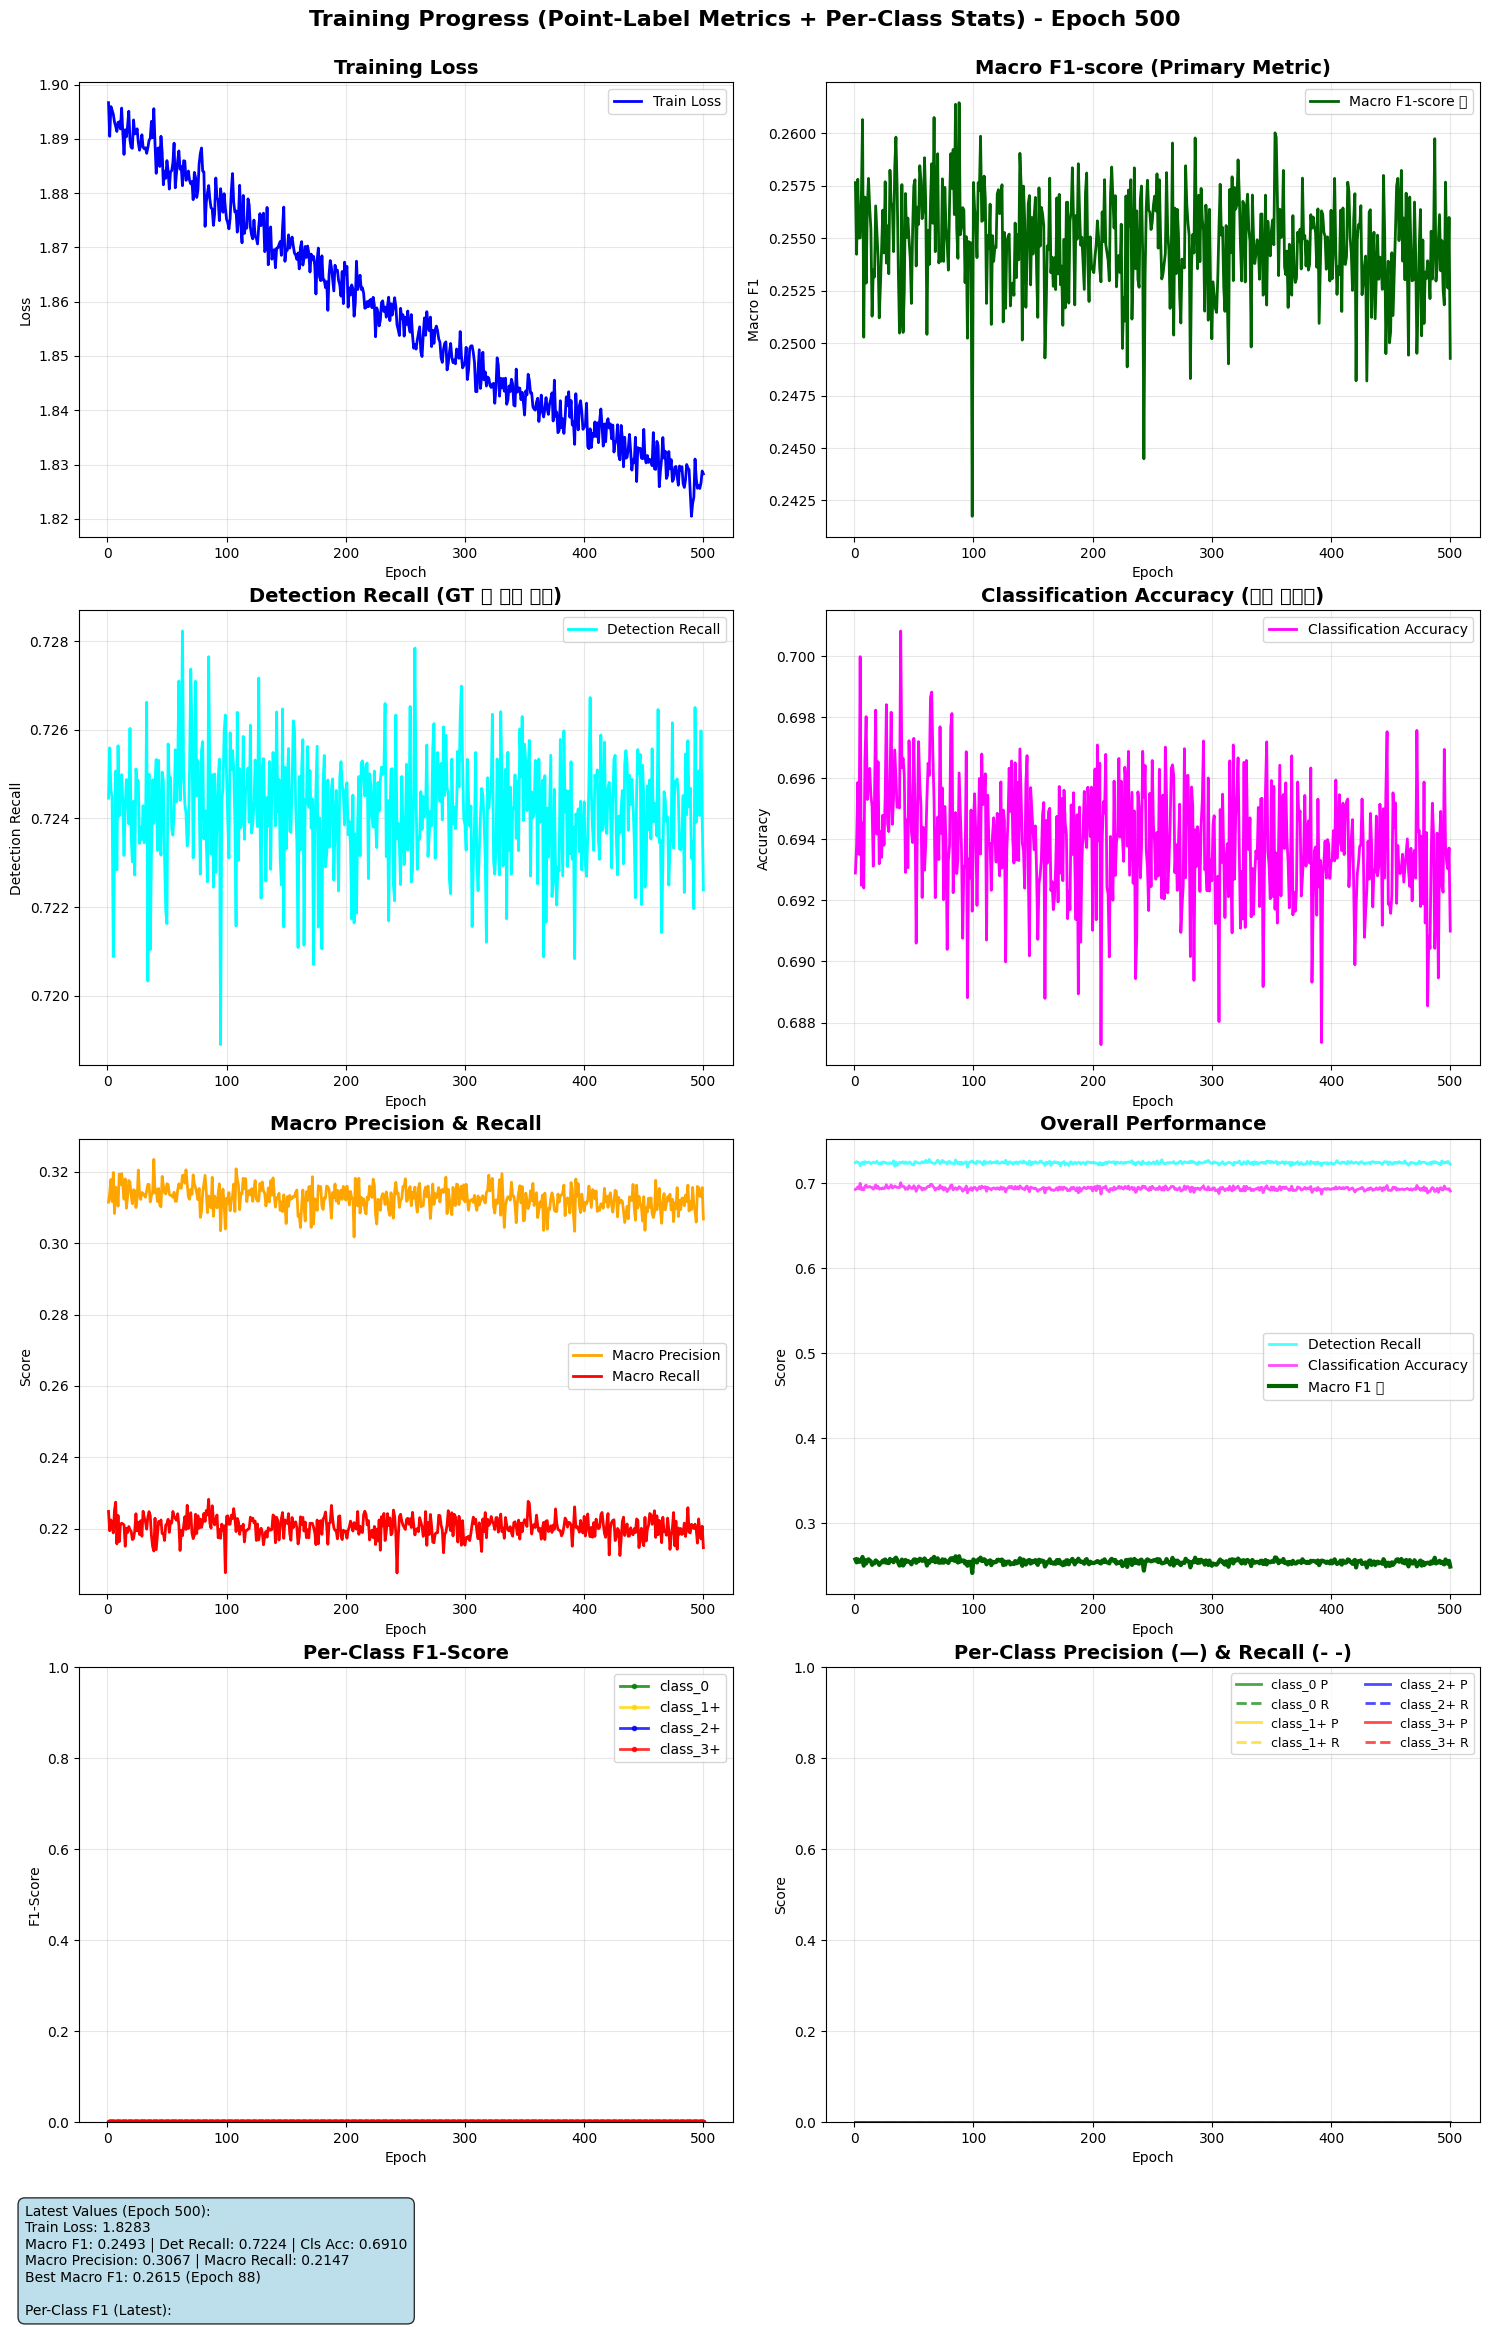


📊 Epoch 500 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_500.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_500.png


Epoch 501/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 501/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 501/10000 Results:
  Train Loss - Box: 0.6777, Cls: 0.6207, DFL: 0.5317, Total: 1.8301
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3147
  Macro Recall: 0.2165
  Macro F1-score: 0.2523 ⭐
  Overall Recall: 0.5022


Epoch 502/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]




Epoch 502/10000 Results:
  Train Loss - Box: 0.6762, Cls: 0.6186, DFL: 0.5316, Total: 1.8264
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3086
  Macro Recall: 0.2219
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5022


Epoch 503/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]




Epoch 503/10000 Results:
  Train Loss - Box: 0.6752, Cls: 0.6181, DFL: 0.5315, Total: 1.8248
🎯 Point-Label Metrics:
  Detection Recall: 0.7228 (GT 중 찾은 비율)
  Classification Accuracy: 0.6940 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3110
  Macro Recall: 0.2186
  Macro F1-score: 0.2526 ⭐
  Overall Recall: 0.5016


Epoch 504/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 504/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 504/10000 Results:
  Train Loss - Box: 0.6759, Cls: 0.6187, DFL: 0.5316, Total: 1.8262
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6929 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3099
  Macro Recall: 0.2204
  Macro F1-score: 0.2539 ⭐
  Overall Recall: 0.5017


Epoch 505/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]
Epoch 505/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]



Epoch 505/10000 Results:
  Train Loss - Box: 0.6754, Cls: 0.6181, DFL: 0.5316, Total: 1.8251
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6951 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3161
  Macro Recall: 0.2204
  Macro F1-score: 0.2557 ⭐
  Overall Recall: 0.5029


Epoch 506/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 506/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 506/10000 Results:
  Train Loss - Box: 0.6740, Cls: 0.6159, DFL: 0.5315, Total: 1.8213
🎯 Point-Label Metrics:
  Detection Recall: 0.7264 (GT 중 찾은 비율)
  Classification Accuracy: 0.6941 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3079
  Macro Recall: 0.2196
  Macro F1-score: 0.2533 ⭐
  Overall Recall: 0.5042


Epoch 507/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 507/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 507/10000 Results:
  Train Loss - Box: 0.6757, Cls: 0.6177, DFL: 0.5316, Total: 1.8250
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6911 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3103
  Macro Recall: 0.2172
  Macro F1-score: 0.2509 ⭐
  Overall Recall: 0.4996


Epoch 508/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 508/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 508/10000 Results:
  Train Loss - Box: 0.6766, Cls: 0.6204, DFL: 0.5317, Total: 1.8286
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3128
  Macro Recall: 0.2212
  Macro F1-score: 0.2556 ⭐
  Overall Recall: 0.5022


Epoch 509/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 509/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 509/10000 Results:
  Train Loss - Box: 0.6747, Cls: 0.6169, DFL: 0.5315, Total: 1.8231
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6932 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3104
  Macro Recall: 0.2207
  Macro F1-score: 0.2546 ⭐
  Overall Recall: 0.5025


Epoch 510/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 510/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 510/10000 Results:
  Train Loss - Box: 0.6765, Cls: 0.6193, DFL: 0.5316, Total: 1.8275
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6951 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3125
  Macro Recall: 0.2155
  Macro F1-score: 0.2509 ⭐
  Overall Recall: 0.5033

📊 Epoch 510 - 검증 샘플 1/1:

📊 Epoch 510 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_510.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_510.png


Epoch 511/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 511/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 511/10000 Results:
  Train Loss - Box: 0.6748, Cls: 0.6175, DFL: 0.5316, Total: 1.8239
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6917 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3113
  Macro Recall: 0.2210
  Macro F1-score: 0.2546 ⭐
  Overall Recall: 0.5011


Epoch 512/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 512/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 512/10000 Results:
  Train Loss - Box: 0.6764, Cls: 0.6195, DFL: 0.5316, Total: 1.8275
🎯 Point-Label Metrics:
  Detection Recall: 0.7258 (GT 중 찾은 비율)
  Classification Accuracy: 0.6905 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3088
  Macro Recall: 0.2130
  Macro F1-score: 0.2476 ⭐
  Overall Recall: 0.5011


Epoch 513/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 513/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 513/10000 Results:
  Train Loss - Box: 0.6767, Cls: 0.6192, DFL: 0.5316, Total: 1.8274
🎯 Point-Label Metrics:
  Detection Recall: 0.7259 (GT 중 찾은 비율)
  Classification Accuracy: 0.6930 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3080
  Macro Recall: 0.2234
  Macro F1-score: 0.2563 ⭐
  Overall Recall: 0.5031


Epoch 514/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 514/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 514/10000 Results:
  Train Loss - Box: 0.6754, Cls: 0.6180, DFL: 0.5315, Total: 1.8250
🎯 Point-Label Metrics:
  Detection Recall: 0.7263 (GT 중 찾은 비율)
  Classification Accuracy: 0.6907 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3082
  Macro Recall: 0.2192
  Macro F1-score: 0.2529 ⭐
  Overall Recall: 0.5016


Epoch 515/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 515/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 515/10000 Results:
  Train Loss - Box: 0.6760, Cls: 0.6183, DFL: 0.5315, Total: 1.8259
🎯 Point-Label Metrics:
  Detection Recall: 0.7215 (GT 중 찾은 비율)
  Classification Accuracy: 0.6921 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3093
  Macro Recall: 0.2153
  Macro F1-score: 0.2495 ⭐
  Overall Recall: 0.4994


Epoch 516/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 516/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 516/10000 Results:
  Train Loss - Box: 0.6762, Cls: 0.6195, DFL: 0.5316, Total: 1.8272
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6929 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3126
  Macro Recall: 0.2166
  Macro F1-score: 0.2520 ⭐
  Overall Recall: 0.5021


Epoch 517/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 517/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 517/10000 Results:
  Train Loss - Box: 0.6742, Cls: 0.6172, DFL: 0.5315, Total: 1.8229
🎯 Point-Label Metrics:
  Detection Recall: 0.7221 (GT 중 찾은 비율)
  Classification Accuracy: 0.6936 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3104
  Macro Recall: 0.2158
  Macro F1-score: 0.2511 ⭐
  Overall Recall: 0.5009


Epoch 518/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]




Epoch 518/10000 Results:
  Train Loss - Box: 0.6753, Cls: 0.6182, DFL: 0.5315, Total: 1.8249
🎯 Point-Label Metrics:
  Detection Recall: 0.7240 (GT 중 찾은 비율)
  Classification Accuracy: 0.6925 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3145
  Macro Recall: 0.2200
  Macro F1-score: 0.2548 ⭐
  Overall Recall: 0.5014


Epoch 519/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 519/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 519/10000 Results:
  Train Loss - Box: 0.6731, Cls: 0.6155, DFL: 0.5314, Total: 1.8200
🎯 Point-Label Metrics:
  Detection Recall: 0.7248 (GT 중 찾은 비율)
  Classification Accuracy: 0.6943 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3157
  Macro Recall: 0.2230
  Macro F1-score: 0.2580 ⭐
  Overall Recall: 0.5032


Epoch 520/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]




Epoch 520/10000 Results:
  Train Loss - Box: 0.6749, Cls: 0.6171, DFL: 0.5315, Total: 1.8235
🎯 Point-Label Metrics:
  Detection Recall: 0.7214 (GT 중 찾은 비율)
  Classification Accuracy: 0.6956 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3111
  Macro Recall: 0.2204
  Macro F1-score: 0.2542 ⭐
  Overall Recall: 0.5018

📊 Epoch 520 - 검증 샘플 1/1:

📊 Epoch 520 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_520.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_520.png


Epoch 521/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]




Epoch 521/10000 Results:
  Train Loss - Box: 0.6744, Cls: 0.6167, DFL: 0.5315, Total: 1.8226
🎯 Point-Label Metrics:
  Detection Recall: 0.7251 (GT 중 찾은 비율)
  Classification Accuracy: 0.6932 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3135
  Macro Recall: 0.2196
  Macro F1-score: 0.2546 ⭐
  Overall Recall: 0.5026


Epoch 522/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]
Epoch 522/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]



Epoch 522/10000 Results:
  Train Loss - Box: 0.6744, Cls: 0.6169, DFL: 0.5315, Total: 1.8228
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6928 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3071
  Macro Recall: 0.2226
  Macro F1-score: 0.2552 ⭐
  Overall Recall: 0.5020


Epoch 523/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 523/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 523/10000 Results:
  Train Loss - Box: 0.6744, Cls: 0.6170, DFL: 0.5315, Total: 1.8230
🎯 Point-Label Metrics:
  Detection Recall: 0.7224 (GT 중 찾은 비율)
  Classification Accuracy: 0.6905 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3080
  Macro Recall: 0.2120
  Macro F1-score: 0.2469 ⭐
  Overall Recall: 0.4988


Epoch 524/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]
Epoch 524/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]



Epoch 524/10000 Results:
  Train Loss - Box: 0.6751, Cls: 0.6179, DFL: 0.5315, Total: 1.8245
🎯 Point-Label Metrics:
  Detection Recall: 0.7259 (GT 중 찾은 비율)
  Classification Accuracy: 0.6966 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3161
  Macro Recall: 0.2220
  Macro F1-score: 0.2571 ⭐
  Overall Recall: 0.5057


Epoch 525/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 525/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 525/10000 Results:
  Train Loss - Box: 0.6756, Cls: 0.6183, DFL: 0.5316, Total: 1.8254
🎯 Point-Label Metrics:
  Detection Recall: 0.7244 (GT 중 찾은 비율)
  Classification Accuracy: 0.6920 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3120
  Macro Recall: 0.2168
  Macro F1-score: 0.2520 ⭐
  Overall Recall: 0.5013


Epoch 526/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 526/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 526/10000 Results:
  Train Loss - Box: 0.6757, Cls: 0.6187, DFL: 0.5316, Total: 1.8260
🎯 Point-Label Metrics:
  Detection Recall: 0.7199 (GT 중 찾은 비율)
  Classification Accuracy: 0.6893 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3063
  Macro Recall: 0.2148
  Macro F1-score: 0.2491 ⭐
  Overall Recall: 0.4963


Epoch 527/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]
Epoch 527/10000 | Memory: 33.16G | Box: 0.677 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.65it/s]



Epoch 527/10000 Results:
  Train Loss - Box: 0.6766, Cls: 0.6197, DFL: 0.5316, Total: 1.8279
🎯 Point-Label Metrics:
  Detection Recall: 0.7273 (GT 중 찾은 비율)
  Classification Accuracy: 0.6934 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3150
  Macro Recall: 0.2219
  Macro F1-score: 0.2570 ⭐
  Overall Recall: 0.5043


Epoch 528/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]
Epoch 528/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]



Epoch 528/10000 Results:
  Train Loss - Box: 0.6782, Cls: 0.6214, DFL: 0.5317, Total: 1.8313
🎯 Point-Label Metrics:
  Detection Recall: 0.7265 (GT 중 찾은 비율)
  Classification Accuracy: 0.6942 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3110
  Macro Recall: 0.2216
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5043


Epoch 529/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]




Epoch 529/10000 Results:
  Train Loss - Box: 0.6742, Cls: 0.6170, DFL: 0.5314, Total: 1.8227
🎯 Point-Label Metrics:
  Detection Recall: 0.7248 (GT 중 찾은 비율)
  Classification Accuracy: 0.6932 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3083
  Macro Recall: 0.2193
  Macro F1-score: 0.2528 ⭐
  Overall Recall: 0.5024


Epoch 530/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 530/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 530/10000 Results:
  Train Loss - Box: 0.6752, Cls: 0.6178, DFL: 0.5315, Total: 1.8245
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6918 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3100
  Macro Recall: 0.2137
  Macro F1-score: 0.2480 ⭐
  Overall Recall: 0.5004

📊 Epoch 530 - 검증 샘플 1/1:

📊 Epoch 530 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_530.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_530.png


Epoch 531/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 531/10000 Results:
  Train Loss - Box: 0.6746, Cls: 0.6167, DFL: 0.5315, Total: 1.8228
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6935 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3121
  Macro Recall: 0.2226
  Macro F1-score: 0.2571 ⭐
  Overall Recall: 0.5019


Epoch 532/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]
Epoch 532/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]



Epoch 532/10000 Results:
  Train Loss - Box: 0.6720, Cls: 0.6139, DFL: 0.5313, Total: 1.8173
🎯 Point-Label Metrics:
  Detection Recall: 0.7221 (GT 중 찾은 비율)
  Classification Accuracy: 0.6902 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3094
  Macro Recall: 0.2189
  Macro F1-score: 0.2531 ⭐
  Overall Recall: 0.4984


Epoch 533/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 533/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 533/10000 Results:
  Train Loss - Box: 0.6734, Cls: 0.6155, DFL: 0.5314, Total: 1.8202
🎯 Point-Label Metrics:
  Detection Recall: 0.7230 (GT 중 찾은 비율)
  Classification Accuracy: 0.6919 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3094
  Macro Recall: 0.2186
  Macro F1-score: 0.2516 ⭐
  Overall Recall: 0.5003


Epoch 534/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.619 | DFL: 0.532: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 534/10000 Results:
  Train Loss - Box: 0.6762, Cls: 0.6191, DFL: 0.5316, Total: 1.8269
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6949 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3108
  Macro Recall: 0.2205
  Macro F1-score: 0.2550 ⭐
  Overall Recall: 0.5028


Epoch 535/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]




Epoch 535/10000 Results:
  Train Loss - Box: 0.6752, Cls: 0.6179, DFL: 0.5315, Total: 1.8246
🎯 Point-Label Metrics:
  Detection Recall: 0.7237 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3127
  Macro Recall: 0.2179
  Macro F1-score: 0.2526 ⭐
  Overall Recall: 0.5016


Epoch 536/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 536/10000 | Memory: 33.16G | Box: 0.678 | Cls: 0.621 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 536/10000 Results:
  Train Loss - Box: 0.6779, Cls: 0.6206, DFL: 0.5317, Total: 1.8302
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3091
  Macro Recall: 0.2182
  Macro F1-score: 0.2518 ⭐
  Overall Recall: 0.5015


Epoch 537/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 537/10000 Results:
  Train Loss - Box: 0.6735, Cls: 0.6158, DFL: 0.5314, Total: 1.8206
🎯 Point-Label Metrics:
  Detection Recall: 0.7216 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3093
  Macro Recall: 0.2168
  Macro F1-score: 0.2513 ⭐
  Overall Recall: 0.4995


Epoch 538/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 538/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 538/10000 Results:
  Train Loss - Box: 0.6732, Cls: 0.6163, DFL: 0.5314, Total: 1.8210
🎯 Point-Label Metrics:
  Detection Recall: 0.7228 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3145
  Macro Recall: 0.2164
  Macro F1-score: 0.2525 ⭐
  Overall Recall: 0.5003


Epoch 539/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 539/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 539/10000 Results:
  Train Loss - Box: 0.6734, Cls: 0.6159, DFL: 0.5314, Total: 1.8208
🎯 Point-Label Metrics:
  Detection Recall: 0.7241 (GT 중 찾은 비율)
  Classification Accuracy: 0.6919 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3098
  Macro Recall: 0.2209
  Macro F1-score: 0.2545 ⭐
  Overall Recall: 0.5010


Epoch 540/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 540/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 540/10000 Results:
  Train Loss - Box: 0.6733, Cls: 0.6155, DFL: 0.5314, Total: 1.8201
🎯 Point-Label Metrics:
  Detection Recall: 0.7225 (GT 중 찾은 비율)
  Classification Accuracy: 0.6896 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3030
  Macro Recall: 0.2224
  Macro F1-score: 0.2534 ⭐
  Overall Recall: 0.4982

📊 Epoch 540 - 검증 샘플 1/1:

📊 Epoch 540 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_540.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_540.png


Epoch 541/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 541/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 541/10000 Results:
  Train Loss - Box: 0.6741, Cls: 0.6168, DFL: 0.5315, Total: 1.8223
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6929 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3114
  Macro Recall: 0.2243
  Macro F1-score: 0.2579 ⭐
  Overall Recall: 0.5021


Epoch 542/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]
Epoch 542/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]



Epoch 542/10000 Results:
  Train Loss - Box: 0.6747, Cls: 0.6171, DFL: 0.5315, Total: 1.8232
🎯 Point-Label Metrics:
  Detection Recall: 0.7237 (GT 중 찾은 비율)
  Classification Accuracy: 0.6955 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3128
  Macro Recall: 0.2190
  Macro F1-score: 0.2536 ⭐
  Overall Recall: 0.5033


Epoch 543/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]




Epoch 543/10000 Results:
  Train Loss - Box: 0.6724, Cls: 0.6148, DFL: 0.5313, Total: 1.8186
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6935 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3117
  Macro Recall: 0.2226
  Macro F1-score: 0.2565 ⭐
  Overall Recall: 0.5019


Epoch 544/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]
Epoch 544/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]



Epoch 544/10000 Results:
  Train Loss - Box: 0.6727, Cls: 0.6150, DFL: 0.5314, Total: 1.8191
🎯 Point-Label Metrics:
  Detection Recall: 0.7241 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3081
  Macro Recall: 0.2215
  Macro F1-score: 0.2542 ⭐
  Overall Recall: 0.5016


Epoch 545/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]




Epoch 545/10000 Results:
  Train Loss - Box: 0.6728, Cls: 0.6151, DFL: 0.5313, Total: 1.8192
🎯 Point-Label Metrics:
  Detection Recall: 0.7234 (GT 중 찾은 비율)
  Classification Accuracy: 0.6911 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3107
  Macro Recall: 0.2136
  Macro F1-score: 0.2480 ⭐
  Overall Recall: 0.4999


Epoch 546/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]
Epoch 546/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.63it/s]



Epoch 546/10000 Results:
  Train Loss - Box: 0.6725, Cls: 0.6147, DFL: 0.5313, Total: 1.8186
🎯 Point-Label Metrics:
  Detection Recall: 0.7244 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3093
  Macro Recall: 0.2140
  Macro F1-score: 0.2488 ⭐
  Overall Recall: 0.5015


Epoch 547/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]
Epoch 547/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]



Epoch 547/10000 Results:
  Train Loss - Box: 0.6737, Cls: 0.6164, DFL: 0.5315, Total: 1.8216
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3113
  Macro Recall: 0.2237
  Macro F1-score: 0.2571 ⭐
  Overall Recall: 0.5015


Epoch 548/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 548/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 548/10000 Results:
  Train Loss - Box: 0.6727, Cls: 0.6150, DFL: 0.5313, Total: 1.8191
🎯 Point-Label Metrics:
  Detection Recall: 0.7238 (GT 중 찾은 비율)
  Classification Accuracy: 0.6958 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3093
  Macro Recall: 0.2200
  Macro F1-score: 0.2529 ⭐
  Overall Recall: 0.5036


Epoch 549/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 549/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 549/10000 Results:
  Train Loss - Box: 0.6743, Cls: 0.6164, DFL: 0.5315, Total: 1.8222
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6949 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3125
  Macro Recall: 0.2202
  Macro F1-score: 0.2550 ⭐
  Overall Recall: 0.5038


Epoch 550/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 550/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 550/10000 Results:
  Train Loss - Box: 0.6750, Cls: 0.6180, DFL: 0.5315, Total: 1.8244
🎯 Point-Label Metrics:
  Detection Recall: 0.7230 (GT 중 찾은 비율)
  Classification Accuracy: 0.6904 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3114
  Macro Recall: 0.2209
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.4991

📊 Epoch 550 - 검증 샘플 1/1:

📊 Epoch 550 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_550.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_550.png


Epoch 551/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 551/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 551/10000 Results:
  Train Loss - Box: 0.6734, Cls: 0.6157, DFL: 0.5314, Total: 1.8205
🎯 Point-Label Metrics:
  Detection Recall: 0.7254 (GT 중 찾은 비율)
  Classification Accuracy: 0.6919 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3085
  Macro Recall: 0.2235
  Macro F1-score: 0.2558 ⭐
  Overall Recall: 0.5019


Epoch 552/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]
Epoch 552/10000 | Memory: 33.16G | Box: 0.675 | Cls: 0.618 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]



Epoch 552/10000 Results:
  Train Loss - Box: 0.6748, Cls: 0.6180, DFL: 0.5315, Total: 1.8242
🎯 Point-Label Metrics:
  Detection Recall: 0.7266 (GT 중 찾은 비율)
  Classification Accuracy: 0.6944 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3133
  Macro Recall: 0.2238
  Macro F1-score: 0.2570 ⭐
  Overall Recall: 0.5045


Epoch 553/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:29<00:00,  4.73it/s]
Epoch 553/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:29<00:00,  4.73it/s]



Epoch 553/10000 Results:
  Train Loss - Box: 0.6733, Cls: 0.6161, DFL: 0.5314, Total: 1.8209
🎯 Point-Label Metrics:
  Detection Recall: 0.7252 (GT 중 찾은 비율)
  Classification Accuracy: 0.6927 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3110
  Macro Recall: 0.2206
  Macro F1-score: 0.2547 ⭐
  Overall Recall: 0.5023


Epoch 554/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]
Epoch 554/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]



Epoch 554/10000 Results:
  Train Loss - Box: 0.6734, Cls: 0.6157, DFL: 0.5314, Total: 1.8205
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6941 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3063
  Macro Recall: 0.2207
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.5032


Epoch 555/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]
Epoch 555/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]



Epoch 555/10000 Results:
  Train Loss - Box: 0.6739, Cls: 0.6162, DFL: 0.5314, Total: 1.8215
🎯 Point-Label Metrics:
  Detection Recall: 0.7235 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3100
  Macro Recall: 0.2207
  Macro F1-score: 0.2547 ⭐
  Overall Recall: 0.5009


Epoch 556/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]




Epoch 556/10000 Results:
  Train Loss - Box: 0.6733, Cls: 0.6157, DFL: 0.5314, Total: 1.8203
🎯 Point-Label Metrics:
  Detection Recall: 0.7252 (GT 중 찾은 비율)
  Classification Accuracy: 0.6908 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3097
  Macro Recall: 0.2174
  Macro F1-score: 0.2521 ⭐
  Overall Recall: 0.5010


Epoch 557/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 557/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 557/10000 Results:
  Train Loss - Box: 0.6723, Cls: 0.6150, DFL: 0.5313, Total: 1.8186
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6918 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3097
  Macro Recall: 0.2190
  Macro F1-score: 0.2531 ⭐
  Overall Recall: 0.5015


Epoch 558/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]
Epoch 558/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.68it/s]



Epoch 558/10000 Results:
  Train Loss - Box: 0.6739, Cls: 0.6164, DFL: 0.5314, Total: 1.8217
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3101
  Macro Recall: 0.2213
  Macro F1-score: 0.2549 ⭐
  Overall Recall: 0.5020


Epoch 559/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 559/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 559/10000 Results:
  Train Loss - Box: 0.6737, Cls: 0.6160, DFL: 0.5314, Total: 1.8212
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6936 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3111
  Macro Recall: 0.2162
  Macro F1-score: 0.2513 ⭐
  Overall Recall: 0.5026


Epoch 560/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]
Epoch 560/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]



Epoch 560/10000 Results:
  Train Loss - Box: 0.6728, Cls: 0.6156, DFL: 0.5313, Total: 1.8198
🎯 Point-Label Metrics:
  Detection Recall: 0.7243 (GT 중 찾은 비율)
  Classification Accuracy: 0.6941 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3128
  Macro Recall: 0.2191
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.5027

📊 Epoch 560 - 검증 샘플 1/1:

📊 Epoch 560 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_560.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_560.png


Epoch 561/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 561/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 561/10000 Results:
  Train Loss - Box: 0.6723, Cls: 0.6152, DFL: 0.5313, Total: 1.8188
🎯 Point-Label Metrics:
  Detection Recall: 0.7241 (GT 중 찾은 비율)
  Classification Accuracy: 0.6930 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3142
  Macro Recall: 0.2182
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.5018


Epoch 562/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 562/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 562/10000 Results:
  Train Loss - Box: 0.6730, Cls: 0.6158, DFL: 0.5314, Total: 1.8202
🎯 Point-Label Metrics:
  Detection Recall: 0.7234 (GT 중 찾은 비율)
  Classification Accuracy: 0.6914 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3097
  Macro Recall: 0.2205
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.5001


Epoch 563/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 563/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 563/10000 Results:
  Train Loss - Box: 0.6735, Cls: 0.6163, DFL: 0.5314, Total: 1.8212
🎯 Point-Label Metrics:
  Detection Recall: 0.7226 (GT 중 찾은 비율)
  Classification Accuracy: 0.6894 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3076
  Macro Recall: 0.2204
  Macro F1-score: 0.2539 ⭐
  Overall Recall: 0.4982


Epoch 564/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 564/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 564/10000 Results:
  Train Loss - Box: 0.6730, Cls: 0.6155, DFL: 0.5313, Total: 1.8199
🎯 Point-Label Metrics:
  Detection Recall: 0.7232 (GT 중 찾은 비율)
  Classification Accuracy: 0.6926 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3076
  Macro Recall: 0.2240
  Macro F1-score: 0.2557 ⭐
  Overall Recall: 0.5009


Epoch 565/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]
Epoch 565/10000 | Memory: 33.16G | Box: 0.676 | Cls: 0.620 | DFL: 0.532: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]



Epoch 565/10000 Results:
  Train Loss - Box: 0.6763, Cls: 0.6196, DFL: 0.5316, Total: 1.8274
🎯 Point-Label Metrics:
  Detection Recall: 0.7254 (GT 중 찾은 비율)
  Classification Accuracy: 0.6962 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3148
  Macro Recall: 0.2183
  Macro F1-score: 0.2539 ⭐
  Overall Recall: 0.5050


Epoch 566/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 566/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 566/10000 Results:
  Train Loss - Box: 0.6742, Cls: 0.6171, DFL: 0.5314, Total: 1.8227
🎯 Point-Label Metrics:
  Detection Recall: 0.7259 (GT 중 찾은 비율)
  Classification Accuracy: 0.6949 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3136
  Macro Recall: 0.2187
  Macro F1-score: 0.2538 ⭐
  Overall Recall: 0.5045


Epoch 567/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 567/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 567/10000 Results:
  Train Loss - Box: 0.6735, Cls: 0.6170, DFL: 0.5314, Total: 1.8219
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6922 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3094
  Macro Recall: 0.2187
  Macro F1-score: 0.2524 ⭐
  Overall Recall: 0.5020


Epoch 568/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]
Epoch 568/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]



Epoch 568/10000 Results:
  Train Loss - Box: 0.6740, Cls: 0.6172, DFL: 0.5314, Total: 1.8225
🎯 Point-Label Metrics:
  Detection Recall: 0.7227 (GT 중 찾은 비율)
  Classification Accuracy: 0.6922 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3086
  Macro Recall: 0.2162
  Macro F1-score: 0.2507 ⭐
  Overall Recall: 0.5002


Epoch 569/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]
Epoch 569/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]



Epoch 569/10000 Results:
  Train Loss - Box: 0.6723, Cls: 0.6145, DFL: 0.5313, Total: 1.8181
🎯 Point-Label Metrics:
  Detection Recall: 0.7253 (GT 중 찾은 비율)
  Classification Accuracy: 0.6925 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3074
  Macro Recall: 0.2172
  Macro F1-score: 0.2511 ⭐
  Overall Recall: 0.5023


Epoch 570/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 570/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 570/10000 Results:
  Train Loss - Box: 0.6732, Cls: 0.6156, DFL: 0.5313, Total: 1.8201
🎯 Point-Label Metrics:
  Detection Recall: 0.7246 (GT 중 찾은 비율)
  Classification Accuracy: 0.6957 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3107
  Macro Recall: 0.2227
  Macro F1-score: 0.2561 ⭐
  Overall Recall: 0.5041

📊 Epoch 570 - 검증 샘플 1/1:

📊 Epoch 570 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_570.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_570.png


Epoch 571/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 571/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 571/10000 Results:
  Train Loss - Box: 0.6729, Cls: 0.6153, DFL: 0.5314, Total: 1.8196
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6925 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3105
  Macro Recall: 0.2188
  Macro F1-score: 0.2529 ⭐
  Overall Recall: 0.5006


Epoch 572/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]
Epoch 572/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]



Epoch 572/10000 Results:
  Train Loss - Box: 0.6716, Cls: 0.6138, DFL: 0.5313, Total: 1.8167
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6917 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3098
  Macro Recall: 0.2227
  Macro F1-score: 0.2557 ⭐
  Overall Recall: 0.5014


Epoch 573/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]
Epoch 573/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.67it/s]



Epoch 573/10000 Results:
  Train Loss - Box: 0.6726, Cls: 0.6149, DFL: 0.5313, Total: 1.8189
🎯 Point-Label Metrics:
  Detection Recall: 0.7236 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3091
  Macro Recall: 0.2179
  Macro F1-score: 0.2509 ⭐
  Overall Recall: 0.5015


Epoch 574/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 574/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 574/10000 Results:
  Train Loss - Box: 0.6729, Cls: 0.6151, DFL: 0.5313, Total: 1.8193
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6964 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3089
  Macro Recall: 0.2183
  Macro F1-score: 0.2522 ⭐
  Overall Recall: 0.5047


Epoch 575/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]




Epoch 575/10000 Results:
  Train Loss - Box: 0.6712, Cls: 0.6132, DFL: 0.5312, Total: 1.8155
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6941 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3099
  Macro Recall: 0.2183
  Macro F1-score: 0.2527 ⭐
  Overall Recall: 0.5030


Epoch 576/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:29<00:00,  4.73it/s]
Epoch 576/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:29<00:00,  4.73it/s]



Epoch 576/10000 Results:
  Train Loss - Box: 0.6717, Cls: 0.6138, DFL: 0.5313, Total: 1.8167
🎯 Point-Label Metrics:
  Detection Recall: 0.7250 (GT 중 찾은 비율)
  Classification Accuracy: 0.6964 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3124
  Macro Recall: 0.2182
  Macro F1-score: 0.2532 ⭐
  Overall Recall: 0.5049


Epoch 577/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]
Epoch 577/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]



Epoch 577/10000 Results:
  Train Loss - Box: 0.6729, Cls: 0.6155, DFL: 0.5313, Total: 1.8197
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6931 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3130
  Macro Recall: 0.2193
  Macro F1-score: 0.2540 ⭐
  Overall Recall: 0.5019


Epoch 578/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]




Epoch 578/10000 Results:
  Train Loss - Box: 0.6711, Cls: 0.6137, DFL: 0.5312, Total: 1.8160
🎯 Point-Label Metrics:
  Detection Recall: 0.7225 (GT 중 찾은 비율)
  Classification Accuracy: 0.6933 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3085
  Macro Recall: 0.2213
  Macro F1-score: 0.2544 ⭐
  Overall Recall: 0.5009


Epoch 579/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 579/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 579/10000 Results:
  Train Loss - Box: 0.6737, Cls: 0.6164, DFL: 0.5314, Total: 1.8215
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6926 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3135
  Macro Recall: 0.2175
  Macro F1-score: 0.2527 ⭐
  Overall Recall: 0.5019


Epoch 580/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]




Epoch 580/10000 Results:
  Train Loss - Box: 0.6716, Cls: 0.6140, DFL: 0.5312, Total: 1.8168
🎯 Point-Label Metrics:
  Detection Recall: 0.7263 (GT 중 찾은 비율)
  Classification Accuracy: 0.6930 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3113
  Macro Recall: 0.2202
  Macro F1-score: 0.2540 ⭐
  Overall Recall: 0.5033

📊 Epoch 580 - 검증 샘플 1/1:

📊 Epoch 580 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_580.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_580.png


Epoch 581/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 581/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 581/10000 Results:
  Train Loss - Box: 0.6722, Cls: 0.6150, DFL: 0.5313, Total: 1.8185
🎯 Point-Label Metrics:
  Detection Recall: 0.7221 (GT 중 찾은 비율)
  Classification Accuracy: 0.6920 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3056
  Macro Recall: 0.2175
  Macro F1-score: 0.2505 ⭐
  Overall Recall: 0.4996


Epoch 582/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 582/10000 | Memory: 33.16G | Box: 0.674 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 582/10000 Results:
  Train Loss - Box: 0.6742, Cls: 0.6171, DFL: 0.5314, Total: 1.8227
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6947 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3083
  Macro Recall: 0.2203
  Macro F1-score: 0.2533 ⭐
  Overall Recall: 0.5034


Epoch 583/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]
Epoch 583/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]



Epoch 583/10000 Results:
  Train Loss - Box: 0.6735, Cls: 0.6162, DFL: 0.5314, Total: 1.8211
🎯 Point-Label Metrics:
  Detection Recall: 0.7260 (GT 중 찾은 비율)
  Classification Accuracy: 0.6916 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3114
  Macro Recall: 0.2206
  Macro F1-score: 0.2553 ⭐
  Overall Recall: 0.5021


Epoch 584/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]
Epoch 584/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]



Epoch 584/10000 Results:
  Train Loss - Box: 0.6711, Cls: 0.6128, DFL: 0.5312, Total: 1.8151
🎯 Point-Label Metrics:
  Detection Recall: 0.7261 (GT 중 찾은 비율)
  Classification Accuracy: 0.6917 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3091
  Macro Recall: 0.2189
  Macro F1-score: 0.2524 ⭐
  Overall Recall: 0.5022


Epoch 585/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 585/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 585/10000 Results:
  Train Loss - Box: 0.6724, Cls: 0.6149, DFL: 0.5313, Total: 1.8185
🎯 Point-Label Metrics:
  Detection Recall: 0.7233 (GT 중 찾은 비율)
  Classification Accuracy: 0.6929 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3049
  Macro Recall: 0.2182
  Macro F1-score: 0.2510 ⭐
  Overall Recall: 0.5011


Epoch 586/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]




Epoch 586/10000 Results:
  Train Loss - Box: 0.6711, Cls: 0.6127, DFL: 0.5312, Total: 1.8150
🎯 Point-Label Metrics:
  Detection Recall: 0.7226 (GT 중 찾은 비율)
  Classification Accuracy: 0.6916 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3111
  Macro Recall: 0.2173
  Macro F1-score: 0.2516 ⭐
  Overall Recall: 0.4998


Epoch 587/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]




Epoch 587/10000 Results:
  Train Loss - Box: 0.6723, Cls: 0.6149, DFL: 0.5313, Total: 1.8185
🎯 Point-Label Metrics:
  Detection Recall: 0.7251 (GT 중 찾은 비율)
  Classification Accuracy: 0.6921 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3094
  Macro Recall: 0.2172
  Macro F1-score: 0.2518 ⭐
  Overall Recall: 0.5019


Epoch 588/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.616 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]




Epoch 588/10000 Results:
  Train Loss - Box: 0.6728, Cls: 0.6155, DFL: 0.5314, Total: 1.8197
🎯 Point-Label Metrics:
  Detection Recall: 0.7245 (GT 중 찾은 비율)
  Classification Accuracy: 0.6949 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3081
  Macro Recall: 0.2211
  Macro F1-score: 0.2541 ⭐
  Overall Recall: 0.5035


Epoch 589/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 589/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 589/10000 Results:
  Train Loss - Box: 0.6709, Cls: 0.6135, DFL: 0.5312, Total: 1.8156
🎯 Point-Label Metrics:
  Detection Recall: 0.7241 (GT 중 찾은 비율)
  Classification Accuracy: 0.6902 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3065
  Macro Recall: 0.2220
  Macro F1-score: 0.2546 ⭐
  Overall Recall: 0.4998


Epoch 590/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]
Epoch 590/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]



Epoch 590/10000 Results:
  Train Loss - Box: 0.6710, Cls: 0.6137, DFL: 0.5312, Total: 1.8159
🎯 Point-Label Metrics:
  Detection Recall: 0.7259 (GT 중 찾은 비율)
  Classification Accuracy: 0.6939 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3118
  Macro Recall: 0.2222
  Macro F1-score: 0.2560 ⭐
  Overall Recall: 0.5037

📊 Epoch 590 - 검증 샘플 1/1:

📊 Epoch 590 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_590.png
✅ 비교 이미지 저장: ../../model/Breast_ST_context/validation_comparison_epoch_590.png


Epoch 591/10000 | Memory: 33.16G | Box: 0.670 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]
Epoch 591/10000 | Memory: 33.16G | Box: 0.670 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]



Epoch 591/10000 Results:
  Train Loss - Box: 0.6701, Cls: 0.6129, DFL: 0.5311, Total: 1.8142
🎯 Point-Label Metrics:
  Detection Recall: 0.7261 (GT 중 찾은 비율)
  Classification Accuracy: 0.6941 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3135
  Macro Recall: 0.2202
  Macro F1-score: 0.2547 ⭐
  Overall Recall: 0.5040


Epoch 592/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]
Epoch 592/10000 | Memory: 33.16G | Box: 0.673 | Cls: 0.617 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]



Epoch 592/10000 Results:
  Train Loss - Box: 0.6731, Cls: 0.6166, DFL: 0.5313, Total: 1.8211
🎯 Point-Label Metrics:
  Detection Recall: 0.7229 (GT 중 찾은 비율)
  Classification Accuracy: 0.6920 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3107
  Macro Recall: 0.2189
  Macro F1-score: 0.2529 ⭐
  Overall Recall: 0.5002


Epoch 593/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]
Epoch 593/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.615 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.66it/s]



Epoch 593/10000 Results:
  Train Loss - Box: 0.6721, Cls: 0.6147, DFL: 0.5313, Total: 1.8180
🎯 Point-Label Metrics:
  Detection Recall: 0.7224 (GT 중 찾은 비율)
  Classification Accuracy: 0.6916 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3118
  Macro Recall: 0.2191
  Macro F1-score: 0.2535 ⭐
  Overall Recall: 0.4996


Epoch 594/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]
Epoch 594/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.72it/s]



Epoch 594/10000 Results:
  Train Loss - Box: 0.6714, Cls: 0.6138, DFL: 0.5312, Total: 1.8164
🎯 Point-Label Metrics:
  Detection Recall: 0.7242 (GT 중 찾은 비율)
  Classification Accuracy: 0.6957 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3102
  Macro Recall: 0.2210
  Macro F1-score: 0.2546 ⭐
  Overall Recall: 0.5039


Epoch 595/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]
Epoch 595/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.70it/s]



Epoch 595/10000 Results:
  Train Loss - Box: 0.6707, Cls: 0.6131, DFL: 0.5312, Total: 1.8150
🎯 Point-Label Metrics:
  Detection Recall: 0.7266 (GT 중 찾은 비율)
  Classification Accuracy: 0.6917 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3089
  Macro Recall: 0.2203
  Macro F1-score: 0.2532 ⭐
  Overall Recall: 0.5026


Epoch 596/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 596/10000 | Memory: 33.16G | Box: 0.672 | Cls: 0.614 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 596/10000 Results:
  Train Loss - Box: 0.6717, Cls: 0.6144, DFL: 0.5312, Total: 1.8173
🎯 Point-Label Metrics:
  Detection Recall: 0.7249 (GT 중 찾은 비율)
  Classification Accuracy: 0.6938 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3140
  Macro Recall: 0.2172
  Macro F1-score: 0.2522 ⭐
  Overall Recall: 0.5029


Epoch 597/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]
Epoch 597/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:31<00:00,  4.67it/s]



Epoch 597/10000 Results:
  Train Loss - Box: 0.6710, Cls: 0.6126, DFL: 0.5312, Total: 1.8148
🎯 Point-Label Metrics:
  Detection Recall: 0.7255 (GT 중 찾은 비율)
  Classification Accuracy: 0.6924 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3091
  Macro Recall: 0.2213
  Macro F1-score: 0.2548 ⭐
  Overall Recall: 0.5023


Epoch 598/10000 | Memory: 33.16G | Box: 0.670 | Cls: 0.612 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]
Epoch 598/10000 | Memory: 33.16G | Box: 0.670 | Cls: 0.612 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.71it/s]



Epoch 598/10000 Results:
  Train Loss - Box: 0.6695, Cls: 0.6118, DFL: 0.5311, Total: 1.8124
🎯 Point-Label Metrics:
  Detection Recall: 0.7247 (GT 중 찾은 비율)
  Classification Accuracy: 0.6960 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3112
  Macro Recall: 0.2210
  Macro F1-score: 0.2551 ⭐
  Overall Recall: 0.5043


Epoch 599/10000 | Memory: 33.16G | Box: 0.669 | Cls: 0.610 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 599/10000 | Memory: 33.16G | Box: 0.669 | Cls: 0.610 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]



Epoch 599/10000 Results:
  Train Loss - Box: 0.6687, Cls: 0.6104, DFL: 0.5310, Total: 1.8102
🎯 Point-Label Metrics:
  Detection Recall: 0.7239 (GT 중 찾은 비율)
  Classification Accuracy: 0.6923 (찾은 세포의 분류 정확도)
  Macro Precision: 0.3059
  Macro Recall: 0.2164
  Macro F1-score: 0.2500 ⭐
  Overall Recall: 0.5012


Epoch 600/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]
Epoch 600/10000 | Memory: 33.16G | Box: 0.671 | Cls: 0.613 | DFL: 0.531: 100%|██████████| 425/425 [01:30<00:00,  4.69it/s]


In [ ]:
from utils.valid import compute_point_label_metrics  # Point-label 최적화 메트릭
from utils.valid import visualize_ground_truth_and_prediction_separately
from utils.valid import plot_training_progress


# main.py의 train 함수를 참조한 개선된 학습 루프
train_losses = []

# Point-label 메트릭용 리스트
val_det_recalls = []  # Detection Recall
val_cls_accs = []     # Classification Accuracy
val_macro_f1s = []    # Macro F1-score
val_macro_precisions = []  # Macro Precision
val_macro_recalls = []  # Macro Recall

# 클래스별 통계 저장용 리스트 (각 에폭마다 class_stats dict 저장)
val_class_stats_history = []

epochs = 10000
# scale_list = [256, 288, 320, 352, 384, 416, 448, 480, 512]
scale_list = [512]
# 체크포인트 저장을 위한 디렉토리 생성
save_dir = '../../model/Breast_ST_context/'
os.makedirs(save_dir, exist_ok=True)
#체크포인트 불러오기 
checkpoint_path = os.path.join(save_dir, 'last_model.pt')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
# main.py 스타일의 설정들
best_macro_f1 = 0  # 베스트 모델 기준: macro_f1
accumulate = max(round(64 / batch_size), 1)  # gradient accumulation steps
amp_scale = torch.amp.GradScaler()  # mixed precision scaler

print(f"Gradient accumulation steps: {accumulate}")

for epoch in range(epochs):
    # 훈련
    model.train()
    
    # main.py 스타일의 평균 손실 추적
    avg_box_loss = util.AverageMeter()
    avg_cls_loss = util.AverageMeter()
    avg_dfl_loss = util.AverageMeter()
    
    train_pbar = tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch+1}/{epochs} Training')
    
    optimizer.zero_grad()
    current_scale = random.choice(scale_list)
    train_dataset.set_scale(current_scale)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn1,
        drop_last=True
    )
    for i, (torch_images, tissue_images, targets) in train_pbar:
        step = i + len(loader) * epoch
        torch_images = torch_images.to(device).float() / 255
        tissue_images = tissue_images.to(device).float() / 255
        
        # Forward pass with mixed precision (tissue context 포함)
        with torch.amp.autocast('cuda'):
            outputs = model(torch_images, tissue_context=tissue_images)
            loss_box, loss_cls, loss_dfl = criterion(outputs, targets)
        
        # 평균 손실 업데이트
        avg_box_loss.update(loss_box.item(), torch_images.size(0))
        avg_cls_loss.update(loss_cls.item(), torch_images.size(0))
        avg_dfl_loss.update(loss_dfl.item(), torch_images.size(0))
        
        # Loss scaling for gradient accumulation
        loss_box *= batch_size  # loss scaled by batch_size
        loss_cls *= batch_size  # loss scaled by batch_size  
        loss_dfl *= batch_size  # loss scaled by batch_size
        
        total_loss = loss_box + loss_cls + loss_dfl
        
        # Backward pass with gradient scaling
        amp_scale.scale(total_loss).backward()
        
        # Gradient accumulation 및 optimization
        if step % accumulate == 0:
            # Gradient clipping 및 optimization
            amp_scale.step(optimizer)
            amp_scale.update()
            optimizer.zero_grad()
        
        # GPU 메모리 동기화
        torch.cuda.synchronize()
        
        # 진행률 표시 업데이트 (main.py 스타일)
        memory = f'{torch.cuda.memory_reserved() / 1E9:.4g}G'
        s = f'Memory: {memory} | Box: {avg_box_loss.avg:.3f} | Cls: {avg_cls_loss.avg:.3f} | DFL: {avg_dfl_loss.avg:.3f}'
        train_pbar.set_description(f'Epoch {epoch+1}/{epochs} | {s}')
    
    # 에폭 평균 손실 계산
    avg_train_loss = avg_box_loss.avg + avg_cls_loss.avg + avg_dfl_loss.avg
    train_losses.append(avg_train_loss)
    val_dataset.set_scale(512)
    
    # Point-label 최적화 메트릭 계산 (주요 평가 지표)
    point_metrics = compute_point_label_metrics(
        model, val_loader, device, params, distance_threshold=16
    )
    
    detection_recall = point_metrics.get('detection_recall', 0)
    cls_accuracy = point_metrics.get('classification_accuracy', 0)
    macro_precision = point_metrics.get('macro_precision', 0)
    macro_recall = point_metrics.get('macro_recall', 0)
    macro_f1 = point_metrics.get('macro_f1', 0)
    overall_recall = point_metrics.get('overall_recall', 0)
    class_stats = point_metrics.get('class_stats', {})
    
    val_det_recalls.append(detection_recall)
    val_cls_accs.append(cls_accuracy)
    val_macro_f1s.append(macro_f1)
    val_macro_precisions.append(macro_precision)
    val_macro_recalls.append(macro_recall)
    
    # 클래스별 통계 저장
    val_class_stats_history.append(class_stats)
    
    # 결과 출력
    print(f"\nEpoch {epoch+1}/{epochs} Results:")
    print(f"  Train Loss - Box: {avg_box_loss.avg:.4f}, Cls: {avg_cls_loss.avg:.4f}, DFL: {avg_dfl_loss.avg:.4f}, Total: {avg_train_loss:.4f}")
    print(f"🎯 Point-Label Metrics:")
    print(f"  Detection Recall: {detection_recall:.4f} (GT 중 찾은 비율)")
    print(f"  Classification Accuracy: {cls_accuracy:.4f} (찾은 세포의 분류 정확도)")
    print(f"  Macro Precision: {macro_precision:.4f}")
    print(f"  Macro Recall: {macro_recall:.4f}")
    print(f"  Macro F1-score: {macro_f1:.4f} ⭐")
    print(f"  Overall Recall: {overall_recall:.4f}")
    
    
    # 베스트 모델 저장 (Macro F1 기준)
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        save_checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'amp_scale_state_dict': amp_scale.state_dict(),
            'train_loss': avg_train_loss,
            'box_loss': avg_box_loss.avg,
            'cls_loss': avg_cls_loss.avg,
            'dfl_loss': avg_dfl_loss.avg,
            # Point-label 메트릭
            'detection_recall': detection_recall,
            'classification_accuracy': cls_accuracy,
            'macro_precision': macro_precision,
            'macro_recall': macro_recall,
            'macro_f1': macro_f1,
            'overall_recall': overall_recall,
            'class_stats': class_stats,
            'params': params
        }
        torch.save(save_checkpoint, os.path.join(save_dir, 'best_model.pt'))
        print(f"🎉 새로운 베스트 모델 저장! Macro F1: {macro_f1:.4f}")
    
    # 최신 모델도 저장 (main.py 스타일)
    last_checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'amp_scale_state_dict': amp_scale.state_dict(),
        'train_loss': avg_train_loss,
        'box_loss': avg_box_loss.avg,
        'cls_loss': avg_cls_loss.avg,
        'dfl_loss': avg_dfl_loss.avg,
        # Point-label 메트릭
        'detection_recall': detection_recall,
        'classification_accuracy': cls_accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'overall_recall': overall_recall,
        'class_stats': class_stats,
        'params': params
    }
    torch.save(last_checkpoint, os.path.join(save_dir, 'last_model.pt'))
    
    # 100 에폭마다 학습 진행 그래프 생성 및 저장 (Point-label 메트릭 + 클래스별 성능)
    if (epoch + 1) % 100 == 0:
        try:
            print(f"\n📊 Epoch {epoch+1} - 학습 진행 상황 그래프 생성 중...")
            plot_training_progress(
                train_losses, val_det_recalls, val_cls_accs, val_macro_precisions, 
                val_macro_recalls, val_macro_f1s, epoch+1, save_dir, 
                class_stats_history=val_class_stats_history
            )
        except Exception as e:
            print(f"그래프 생성 중 오류: {e}")
    
    # 개선된 검증 이미지 시각화 (매 10 에폭마다) - 실제 라벨과 예측 라벨을 별도 figure로 표시
    if (epoch+1) % 10 == 0:
        try:
            # 여러 샘플에 대해 시각화
            num_samples = 1 # 샘플 수를 1개
            for sample_idx in range(num_samples):
                print(f"\n📊 Epoch {epoch+1} - 검증 샘플 {sample_idx+1}/{num_samples}:")
                print("=" * 60)
                
                # 실제 라벨과 예측 라벨을 별도 figure로 표시
                sample_idx = random.randint(0, len(val_dataset)-1)
                visualize_ground_truth_and_prediction_separately(
                    model, val_dataset, idx=sample_idx, 
                    epoch=epoch+1, save_dir=save_dir
                )
                
        except Exception as e:
            print(f"시각화 중 오류: {e}")

print("🎯 학습 완료!")
print(f"최종 베스트 Macro F1: {best_macro_f1:.4f}")
print(f"모델 저장 위치: {save_dir}")
print(f"베스트 모델: {os.path.join(save_dir, 'best_model.pt')}")
print(f"최신 모델: {os.path.join(save_dir, 'last_model.pt')}")

# 최종 성능 요약
if val_macro_f1s:
    final_macro_f1 = val_macro_f1s[-1]
    final_det_recall = val_det_recalls[-1]
    final_cls_acc = val_cls_accs[-1]
    final_macro_precision = val_macro_precisions[-1]
    final_macro_recall = val_macro_recalls[-1]
    
    print(f"\n📊 최종 성능 요약 (Point-Label Metrics):")
    print(f"  Macro F1-score: {final_macro_f1:.4f} ⭐")
    print(f"  Macro Precision: {final_macro_precision:.4f}")
    print(f"  Macro Recall: {final_macro_recall:.4f}")
    print(f"  Detection Recall: {final_det_recall:.4f}")
    print(f"  Classification Accuracy: {final_cls_acc:.4f}")


In [ ]:
from utils.valid import compute_point_label_metrics  # Point-label 최적화 메트릭
from utils.valid import visualize_ground_truth_and_prediction_separately
from utils.valid import plot_training_progress


# main.py의 train 함수를 참조한 개선된 학습 루프
train_losses = []

# Point-label 메트릭용 리스트
val_det_recalls = []  # Detection Recall
val_cls_accs = []     # Classification Accuracy
val_macro_f1s = []    # Macro F1-score
val_macro_precisions = []  # Macro Precision
val_macro_recalls = []  # Macro Recall

# 클래스별 통계 저장용 리스트 (각 에폭마다 class_stats dict 저장)
val_class_stats_history = []

epochs = 10000
# scale_list = [256, 288, 320, 352, 384, 416, 448, 480, 512]
scale_list = [512]
# 체크포인트 저장을 위한 디렉토리 생성
save_dir = '../../model/Breast_ST_context/'
os.makedirs(save_dir, exist_ok=True)
#체크포인트 불러오기 
checkpoint_path = os.path.join(save_dir, 'last_model.pt')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
sample_idx = random.randint(0, len(val_dataset)-1)
visualize_ground_truth_and_prediction_separately(
                    model, val_dataset, idx=sample_idx, 
                    epoch=1, save_dir=save_dir,conf_threshold=0.1,
                    iou_threshold=0.1
                )

In [ ]:
# Cohen's Kappa 관련 함수들을 valid.py에서 import
from utils.valid import compute_validation_metrics_with_kappa, get_kappa_interpretation, quick_kappa_test

# 현재 모델의 빠른 Cohen's Kappa 테스트
print("🔍 현재 모델의 Cohen's Kappa 빠른 측정...")
current_kappa = quick_kappa_test(model, val_loader, device)